In [521]:
import os 

os.environ["TORCH_HOME"]="/home/jovyan/shares/SR006.nfs2/.cache"
os.environ["HF_HOME"]="/home/jovyan/shares/SR006.nfs2/.cache"
os.environ["HUGGINGFACE_HUB_CACHE"]="/home/jovyan/shares/SR006.nfs2/.cache"
os.environ["HF_DATASETS_CACHE"]="/home/jovyan/shares/SR006.nfs2/.cache"

import datasets
import json
import numpy as np
import pandas as pd
import torch
from collections import defaultdict

from sklearn.metrics import roc_auc_score
from lm_polygraph.utils.manager import UEManager, _delete_nans, _recombine_data
from lm_polygraph.ue_metrics.ue_metric import get_random_scores
from lm_polygraph.ue_metrics.risk_cov_curve import RiskCoverageCurveAUC
from lm_polygraph.ue_metrics.pred_rej_area import PredictionRejectionArea
from transformers import AutoTokenizer

prr = PredictionRejectionArea()

# CoQA

## Vicuna 7b

In [46]:
path = "lm-polygraph/workdir/output/qa/lmsys/vicuna-7b-v1.5/coqa/2024-04-09/22-25-24/ue_manager_seed1"
man = UEManager.load(path)

metric_names = ['Accuracy', 'AlignScore']
df = {}
for key in man.metrics.keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man.metrics[key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'CoQA, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"CoQA, {metric_names[-1]}, PRR", ascending=False).style.background_gradient(axis=0)

Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x7fc48b67cf40>]


,"CoQA, Accuracy, PRR","CoQA, AlignScore, PRR"
MaximumSequenceProbability,0.485674,0.426848
"TokenMahalanobisDistance_decoder (mean, accuracy, 1.0)",0.727515,0.398484
"RelativeMahalanobisDistance_decoder (sum, alignscore, 0.9)",0.716602,0.395771
"RelativeMahalanobisDistance_decoder (sum, accuracy, 1.0)",0.769119,0.394056
"RelativeMahalanobisDistance_decoder (mean, accuracy, 1.0)",0.738503,0.393038
"TokenMahalanobisDistance_decoder (sum, accuracy, 1.0)",0.755343,0.392636
"TokenMahalanobisDistance_decoder (mean, alignscore, 0.9)",0.665990,0.391263
"TokenMahalanobisDistance_decoder (sum, alignscore, 0.9)",0.744779,0.390905
"TokenMahalanobisDistance_decoder (sum, alignscore, 0.5)",0.743296,0.388285
"TokenMahalanobisDistance_decoder (sum, alignscore, 0.0)",0.740978,0.383136


In [47]:
np.mean(man.gen_metrics[('sequence', 'Accuracy')])

0.311

## Vicuna-13b

In [49]:
path = "lm-polygraph/workdir/output/qa/lmsys/vicuna-13b-v1.5/coqa/2024-04-09/22-25-46/ue_manager_seed1"
man = UEManager.load(path)

metric_names = ['Accuracy', 'AlignScore']
df = {}
for key in man.metrics.keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man.metrics[key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'CoQA, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"CoQA, {metric_names[-1]}, PRR", ascending=False).style.background_gradient(axis=0)

Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x7fc48b67cf40>]


,"CoQA, Accuracy, PRR","CoQA, AlignScore, PRR"
MaximumSequenceProbability,0.571644,0.476971
"TokenMahalanobisDistance_decoder (mean, accuracy, 1.0)",0.669625,0.424662
"TokenMahalanobisDistance_decoder (mean, alignscore, 0.9)",0.594895,0.415991
"RelativeMahalanobisDistance_decoder (mean, accuracy, 1.0)",0.682688,0.398452
"TokenMahalanobisDistance_decoder (mean, alignscore, 0.5)",0.582878,0.397330
"RelativeMahalanobisDistance_decoder (sum, accuracy, 1.0)",0.711412,0.355334
"RelativeMahalanobisDistance_decoder (sum, alignscore, 0.9)",0.614735,0.354281
"TokenMahalanobisDistance_decoder (mean, alignscore, 0.0)",0.568651,0.353172
"RelativeMahalanobisDistance_decoder (mean, alignscore, 0.9)",0.598521,0.350778
"TokenMahalanobisDistance_decoder (sum, accuracy, 1.0)",0.698367,0.344116


In [50]:
np.mean(man.gen_metrics[('sequence', 'Accuracy')])

0.398

## Mistral 7b

In [121]:
path = "lm-polygraph/workdir/output/qa/alpindale/Mistral-7B-v0.2-hf/coqa/2024-04-10/05-00-05/ue_manager_seed1"
man = UEManager.load(path)

metric_names = ['Accuracy', 'AlignScore']
df = {}
for key in man.metrics.keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man.metrics[key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'CoQA, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"CoQA, {metric_names[-1]}, PRR", ascending=False).style.background_gradient(axis=0)

Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x7fc48b67cf40>]


,"CoQA, Accuracy, PRR","CoQA, AlignScore, PRR"
MaximumSequenceProbability,0.085285,0.225358
Perplexity,0.086268,0.221819
MeanTokenEntropy,0.061717,0.205033
"TokenMahalanobisDistance_decoder (sum, alignscore, 0.9)",0.225555,0.001932
"TokenMahalanobisDistance_decoder (sum, alignscore, 0.5)",0.241225,-0.004349
"TokenMahalanobisDistance_decoder (mean, alignscore, 0.9)",0.229649,-0.006377
"TokenMahalanobisDistance_decoder (sum, accuracy, 1.0)",0.251100,-0.009197
"TokenMahalanobisDistance_decoder (mean, alignscore, 0.5)",0.246404,-0.011738
"TokenMahalanobisDistance_decoder (mean, accuracy, 1.0)",0.256077,-0.016848
"TokenMahalanobisDistance_decoder (sum, alignscore, 0.0)",0.199988,-0.056343


In [122]:
np.mean(man.gen_metrics[('sequence', 'Accuracy')])

0.5705

## Gemma 7b

In [710]:
path = "../workdir/output_layers/qa/google/gemma-7b/coqa/2024-07-10/17-39-01/ue_manager_seed1"#"../workdir/output/qa/google/gemma-7b/coqa/2024-07-03/18-32-21/ue_manager_seed1"
path = "../workdir/output_layers/qa/google/gemma-7b/coqa/2024-07-10/20-59-43/ue_manager_seed1"
path = "../workdir/output_layers/qa/google/gemma-7b/coqa/2024-07-11/10-12-08/ue_manager_seed1"
man = torch.load(path)

metric_names = ['Accuracy', 'AlignScore']
df = {}
for key in man['metrics'].keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man['metrics'][key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'CoQA, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"CoQA, {metric_names[-2]}, PRR", ascending=False).style.background_gradient(axis=0)

,"CoQA, Accuracy, PRR","CoQA, AlignScore, PRR"
MaximumSequenceProbability,0.744787,0.636801
"LinRegTokenMahalanobisDistance_decoder0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,-1 (mean, accuracy, 0.3, pos)",0.652802,0.436014
"TokenMahalanobisDistance_decoder_20 (mean, Accuracy, 0.3)",0.650753,0.420344
"TokenMahalanobisDistance_decoder_21 (mean, Accuracy, 0.3)",0.649612,0.426408
"TokenMahalanobisDistance_decoder_19 (mean, Accuracy, 0.3)",0.644433,0.424008
"LinRegTokenMahalanobisDistance_decoder0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,-1 (mean, accuracy, 0.3, )",0.626475,0.429063
"TokenMahalanobisDistance_decoder_21 (mean, AlignScore, 0.3)",0.623579,0.427445
"TokenMahalanobisDistance_decoder_20 (mean, AlignScore, 0.3)",0.617811,0.416195
"TokenMahalanobisDistance_decoder_22 (mean, Accuracy, 0.3)",0.616070,0.416389
"TokenMahalanobisDistance_decoder_21 (mean, , 0)",0.615292,0.439224


In [609]:
np.mean(man['gen_metrics'][('sequence', 'Accuracy')])

0.596

/tmp/ipykernel_722/3969248090.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(layers, [df0['MaximumSequenceProbability'][0]]*len(layers), label="MSP")


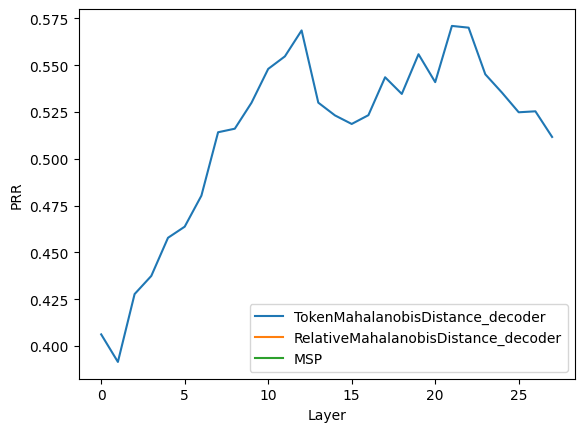

In [625]:
import matplotlib.pyplot as plt

def check_cond(col, name="TokenMahalanobisDistance_decoder", suf="(mean, , 0)"):
    return (name in col) and (suf in col)
names = ["TokenMahalanobisDistance_decoder", "RelativeMahalanobisDistance_decoder"]
for name in names:
    cols = [x for x in df0.columns if check_cond(x, name)]
    layers = [int(x.split("_")[2].split(" ")[0]) if len(x.split("_")) > 2 else 27 for x in cols]
    
    plt.plot(layers, df0[cols].values[0], label=name)
plt.plot(layers, [df0['MaximumSequenceProbability'][0]]*len(layers), label="MSP")
plt.xlabel("Layer")
plt.ylabel("PRR")
plt.legend()

In [1712]:
basepath = "/home/jovyan/shares/SR006.nfs2/projects/token_mahalanobis_distance/"

train_seq_metrics = np.load(f"{basepath}/workdir/output_layers_5/density_stats/sciq/gemma-2b/train_seq_metrics_LinRegTokenMahalanobisDistance_decoder0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,-1 (mean, AlignScore, AlignScore, 0.3, , orig, , ).npy")
train_dists = np.load(f"{basepath}/workdir/output_layers_5/density_stats/sciq/gemma-2b/train_dists_LinRegTokenMahalanobisDistance_decoder0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,-1 (mean, AlignScore, AlignScore, 0.3, , orig, , ).npy")

In [1713]:
train_dists.shape, train_seq_metrics.shape

((750, 18), (1500,))

In [1714]:
train_seq_metrics[0]

0.8228234648704529

In [1715]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import copy

def calculate_vif(X, thresh=5.0):
    # Taken from https://stats.stackexchange.com/a/253620/53565 and modified
    dropped = True
    drp_ind = []
    X_cp = copy.deepcopy(X)
    while dropped:
        feats = np.arange(X.shape[1])
        dropped = False
        vif = [variance_inflation_factor(X, f) for f in feats]
        print(vif)
        max_vif = max(vif)
        if max_vif > thresh:
            maxloc = np.argmax(vif)
            for i in np.arange(X_cp.shape[1]):
                if all(X_cp[:, i] == X[:, maxloc]):
                    drp_ind.append(i)
                    print(i, maxloc)
            X = np.delete(X, maxloc, 1)
            dropped=True
    return X, drp_ind

X_eval_, drp_ind = calculate_vif(copy.deepcopy(train_dists))

[66.00713884552927, 253.60184054339584, 423.8867997487255, 482.0697094943875, 791.7966105132033, 800.5188400608026, 597.5427929460197, 960.415550263602, 1403.9930080942693, 1709.7746995406364, 1878.0332910717968, 1958.9619639210734, 848.0447771051836, 1005.7581075960957, 690.0506939681399, 854.328398977384, 765.9896056470004, 109.98853283347881]
11 11
[65.86313686227896, 253.60160095569856, 423.5543050555018, 479.69311201237764, 782.1149963634563, 800.119692110853, 597.5396754409671, 959.5812788847056, 1386.7923397463685, 1707.6331968011552, 1186.3433838375572, 529.7822924810307, 991.7154293046406, 688.4330105100238, 850.5596499351035, 765.707675899056, 107.79154046552848]
9 9
[65.86202183194669, 253.2377113032732, 423.18555187215463, 478.51424551655475, 782.0395904412003, 793.1818887956065, 596.314980830653, 959.4492330770129, 1092.8533010114313, 661.2283817085748, 529.4121238518248, 989.6643908436797, 683.9284890391862, 841.4352302503656, 751.391886830248, 106.76447185413541]
8 8
[65

In [1716]:
cols = np.argwhere(~np.isin(np.arange(train_dists.shape[1]), drp_ind)).flatten()
cols

array([ 0, 14])

In [1717]:
feats = np.arange(train_dists.shape[1])
removed = np.zeros_like(feats, dtype=bool)
added = np.zeros_like(feats, dtype=bool)

for f in feats:
    if removed[f]:
        continue
    added[f] = True
    corr_idx = np.argwhere((np.abs(np.corrcoef(train_dists.T)[f]) > 0.8) & (np.arange(train_dists.shape[1]) != f)).flatten()
    removed[corr_idx] = True
    print(f, corr_idx)

0 [1 2 3]
4 [1 2 3 5 6 7 8 9]
10 [ 6  7  8  9 11 12 13 14 15]
16 [ 7  8  9 14 15 17]


In [1727]:
from sklearn.cluster import KMeans
X_corr = np.corrcoef(train_dists.T)
kmeans = KMeans(n_clusters=5, random_state=0, n_init="auto").fit(X_corr)

In [1728]:
kmeans.predict(X_corr)

array([1, 1, 1, 2, 2, 2, 2, 2, 0, 0, 0, 0, 3, 3, 3, 4, 4, 4], dtype=int32)

In [1797]:
import scipy
import scipy.cluster.hierarchy as sch

X_corr = np.corrcoef(train_dists.T)
d = sch.distance.pdist(X_corr)
L = sch.linkage(d, method='complete')
clusters = sch.fcluster(L, 0.3*d.max(), 'distance')

In [1798]:
np.unique(clusters).shape

(7,)

In [1791]:
features = []
for cluster in np.unique(clusters):
    cls_features = []
    cls_prr = []
    for f in np.argwhere(clusters == cluster).flatten():
        cls_features.append(f)
        cls_prr.append(np.abs(get_prr(train_dists[:, f], train_seq_metrics[len(train_dists):])))
        print(cluster, f, get_prr(train_dists[:, f], train_seq_metrics[len(train_dists):]))
    features.append(cls_features[np.argmax(cls_prr)]) 

1 0 -0.07344329278503006
1 1 -0.05478151618919073
1 2 -0.05465187596397338
2 9 0.22033881943340616
2 10 0.28353028935647584
2 11 0.28470086346646517
2 12 0.26265248432875266
2 13 0.28258395404639275
2 14 0.2751770796294454
3 3 0.01074720698199815
3 4 0.05341746154331806
3 5 0.07833182237003217
3 6 0.08626488600319404
4 7 0.18478283471453294
4 8 0.21490412295001138
4 15 0.254177776015411
4 16 0.21484664330032746
4 17 0.21049817125277306


In [1792]:
features

[0, 11, 6, 15]

In [ ]:
scores = []
for i in range(train_dists.shape[-1]):
    print(get_prr(train_dists[:N, i], train_seq_metrics[len(train_dists):][:N]))
    scores.append(get_prr(train_dists[:N, i], train_seq_metrics[len(train_dists):][:N]))

weights = np.array(scores)
weights /= weights.sum()
print(weights)

In [1606]:
from sklearn.linear_model import RidgeCV, Ridge, Lasso, SGDRegressor, PassiveAggressiveRegressor, RidgeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import rankdata
scaler = StandardScaler()
X = np.zeros_like(train_dists)
for col in range(train_dists.shape[1]):
    X[:, col] = rankdata(train_dists[:, col])
    #X[:, col] /= X[:, col].max()
X = train_dists
#X /= X.max()
#X = scaler.fit_transform(train_dists)
N = 50
#y = 1 - rankdata(train_seq_metrics[len(train_dists):][:N])
y = 1 - train_seq_metrics[len(train_dists):][:N]
regressor = Ridge(positive=False)
regressor.fit(X[:N], y)
print("COEF:", regressor.coef_)

COEF: [-4.2866639e-04 -5.6469955e-05 -7.6645258e-05  4.4416060e-04
 -1.4559434e-04  2.7497017e-04]


In [1593]:
import numpy as np
from sklearn.model_selection import KFold

coefs = np.zeros(X.shape[1]) 
kf = KFold(n_splits=10)
for i, (train_index, test_index) in enumerate(kf.split(X[:N])):
    regressor_ = Ridge(positive=False)
    regressor_.fit(X[:N][train_index], 1 - rankdata(train_seq_metrics[len(train_dists):][:N][train_index]))
    print("COEF:", regressor_.coef_)
    coefs += regressor_.coef_
    for i in range(train_dists.shape[-1]):
        print(prr(train_dists[:N][test_index, i], train_seq_metrics[len(train_dists):][:N][test_index]))
    print("preds:", prr(regressor_.predict(X)[:N][test_index], train_seq_metrics[len(train_dists):][:N][test_index]))
coefs /= 10

print("preds:", prr(X[N:] @ coefs, train_seq_metrics[len(train_dists):][N:]))

COEF: [-3.8713894  -0.59943557  0.5600364   6.4910297   2.039218    3.6218596 ]
0.2605188277366895
0.7664616145618097
0.7664616145618097
0.7664616145618097
0.7360145879356512
0.6524649787032766
preds: 0.7664616145618097
COEF: [-3.400304  -1.8619442  1.4950522  6.045306   0.9645226  3.4769092]
0.9060750889104444
0.9510901110485641
0.9510901110485641
0.9543382818925853
0.8395087219072324
0.8374353400465158
preds: 0.9547896303781307
COEF: [-7.1444716 -2.7141361 -1.277413  10.421398   1.4259137  4.4881043]
0.8307955712218
0.8411434561074582
0.8411434561074582
0.8307955712218
0.8258247089569075
0.8307955712218
preds: 0.8307955712218
COEF: [-3.3392615 -1.5147388  1.602597   6.3162127  1.3545415  3.0697424]
0.7250119695982009
0.6692693819286396
0.7781662097528307
0.8011511832117149
0.711408499936594
0.7184737283675601
preds: 0.8011511832117149
COEF: [-5.8164473  -0.95932525 -0.5909877   7.7161927  -0.86034197  6.2562423 ]
0.3684200076831258
0.7493947272282717
0.7454620287908446
0.778204452084

In [1594]:
for i in range(train_dists.shape[-1]):
    print(get_prr(train_dists[N:, i], train_seq_metrics[len(train_dists):][N:]))

0.26207122639405167
0.5160524480357692
0.5937761801897197
0.664364879465724
0.33694784250573023
0.41234030413956263


In [1595]:
scores = []
for i in range(train_dists.shape[-1]):
    print(get_prr(train_dists[:N, i], train_seq_metrics[len(train_dists):][:N]))
    scores.append(get_prr(train_dists[:N, i], train_seq_metrics[len(train_dists):][:N]))

weights = np.array(scores)
weights /= weights.sum()
print(weights)

0.3436483443534423
0.38267399094620635
0.546562893233456
0.6431366057391387
0.38670802876385624
0.5307330713187444
[0.1212821  0.13505523 0.19289573 0.22697901 0.13647894 0.18730899]


In [1596]:
train_seq_metrics[len(train_dists):][:N].mean(), train_seq_metrics[len(train_dists):][N:].mean()

(0.7524949737222051, 0.8485593836812768)

In [1597]:
get_prr(train_dists.mean(1)[N:], train_seq_metrics[len(train_dists):][N:])

0.6813676224166774

In [1598]:
y = -rankdata(train_seq_metrics[len(train_dists):][:N])
y = 1 - train_seq_metrics[len(train_dists):][:N]
cols = np.argwhere(~np.isin(np.arange(train_dists.shape[1]), drp_ind)).flatten()
#cols = [0,1,2,3,4,5]

regressor = Ridge(positive=False)
regressor.fit(X[:N:, cols], y)
print("COEF:", regressor.coef_)
get_prr(regressor.predict(X[N:, cols]), train_seq_metrics[len(train_dists):][N:])

COEF: [-0.02191744  0.20990016 -0.0477768 ]


0.6166882675297648

In [1599]:
get_prr(X[N:] @ coefs, train_seq_metrics[len(train_dists):][N:])

0.6578584400548376

In [1600]:
get_prr(X[N:] @ weights, train_seq_metrics[len(train_dists):][N:])

0.7005866041057245

In [1601]:
def get_prr(ue, metric):
    mean_val = prr(ue, metric) 
    oracle = prr(-metric, metric)
    random = get_random_scores(prr, metric)
    final_score = (mean_val - random) / (oracle - random)
    return final_score

In [1607]:
path = "../workdir/output_layers_3/qa/google/gemma-2b/sciq/2024-07-24/12-24-25/ue_manager_seed1"
data = torch.load(path)
layers = [16,15,14,13,0,-1]
X_eval = []
y_eval = np.array(data["gen_metrics"][("sequence", "AlignScore")])
for l in layers:
    if l != -1:
        X_eval.append(data["estimations"][('sequence', f'TokenMahalanobisDistance_decoder_{l} (mean, AlignScore, 0.3)')])
    else:
        X_eval.append(data["estimations"][('sequence', f'TokenMahalanobisDistance_decoder (mean, AlignScore, 0.3)')])
    print(l, get_prr(X_eval[-1], y_eval))

X_eval = np.array(X_eval).T
X_eval.shape, y_eval.shape

16 0.24770591079690205
15 0.31029239544416337
14 0.3307148227984904
13 0.3354824114491844
0 0.0031959965698706784
-1 0.28138133381104774


((100, 6), (100,))

In [1627]:
#y = 1 - rankdata(train_seq_metrics[len(train_dists):])
y = 1 - train_seq_metrics[len(train_dists):]

cols = np.argwhere(~np.isin(np.arange(train_dists.shape[1]), drp_ind)).flatten()
#cols = [0,1,2,3,4,5]
cols = np.argwhere(added).flatten()


regressor = Ridge(positive=False)
regressor.fit(X[:, cols], y)
print("COEF:", regressor.coef_)
get_prr(regressor.predict(X_eval[:, cols]), y_eval)

COEF: [ 2.0242780e-05 -4.2708678e-05  2.5091099e-04 -3.7918951e-05]


0.3818289168468513

In [1820]:
path = "../workdir/output_layers_4/qa/google/gemma-2b/sciq/2024-07-24/12-56-50/ue_manager_seed1"
path = "../workdir/output_layers_5/qa/google/gemma-2b/sciq/2024-07-24/14-59-35/ue_manager_seed1"
#path = "../workdir/output_layers_4/qa/google/gemma-2b/['trivia_qa', 'rc.nocontext']/2024-07-24/13-57-18/ue_manager_seed1"
path = "../workdir/output_layers_5/qa/google/gemma-2b/sciq/2024-07-24/15-30-12/ue_manager_seed1"
path = "../workdir/output_layers_5/qa/google/gemma-2b/sciq/2024-07-24/16-57-07/ue_manager_seed1"
path = "../workdir/output_layers_5/qa/google/gemma-2b/sciq/2024-07-24/17-11-48/ue_manager_seed1"
path = "../workdir/output_layers_5/qa/google/gemma-2b/sciq/2024-07-24/18-28-27/ue_manager_seed1"
path = "../workdir/output_layers_5/ats/google/gemma-2b/samsum/2024-07-24/19-56-02/ue_manager_seed1"
path = "../workdir/output_layers_6/qa/google/gemma-7b/sciq/2024-07-24/17-12-33/ue_manager_seed1"
path = "../workdir/output_layers_5/qa/google/gemma-2b/sciq/2024-07-25/11-17-14/ue_manager_seed1"
path = "../workdir/output_layers_5/qa/google/gemma-2b/sciq/2024-07-25/12-08-13/ue_manager_seed1"
path = "../workdir/output_layers_5/ats/google/gemma-2b/xsum/2024-07-25/12-51-21/ue_manager_seed1"

man = torch.load(path)

metric_names = ['Rouge_rougeL', 'AlignScore']
df = {}
for key in man['metrics'].keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man['metrics'][key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'CoQA, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"CoQA, {metric_names[-1]}, PRR", ascending=False).style.background_gradient(axis=0)

,"CoQA, Rouge_rougeL, PRR","CoQA, AlignScore, PRR"
MeanTokenEntropy,-0.204418,0.387927
Perplexity,-0.215283,0.386088
"LinRegTokenMahalanobisDistance_decoder16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1,0,-1 (mean, AlignScore, AlignScore, 0.3, , orig, tgt_norm, remove_corr_2)",-0.220485,0.308222
"LinRegRelativeTokenMahalanobisDistance_decoder16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1,0,-1 (mean, AlignScore, AlignScore, 0.3, , scaler, tgt_norm, remove_corr_1)",-0.090145,0.304519
"LinRegRelativeTokenMahalanobisDistance_decoder16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1,0,-1 (mean, AlignScore, AlignScore, 0.3, , scaler, tgt_norm, remove_corr_2)",-0.210120,0.299601
"LinRegTokenMahalanobisDistance_decoder16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1,0,-1 (mean, AlignScore, AlignScore, 0.3, , scaler, tgt_norm, remove_corr_2)",-0.193792,0.274631
"LinRegRelativeTokenMahalanobisDistance_decoder16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1,0,-1 (mean, AlignScore, AlignScore, 0.3, , scaler, tgt_norm, )",-0.184369,0.269888
"LinRegRelativeTokenMahalanobisDistance_decoder16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1,0,-1 (mean, AlignScore, AlignScore, 0.3, , orig, tgt_norm, )",-0.094960,0.226074
MaximumSequenceProbability,-0.244002,0.211347
"LinRegRelativeTokenMahalanobisDistance_decoder16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1,0,-1 (mean, AlignScore, AlignScore, 0.3, , orig, tgt_norm, remove_corr_1)",-0.039402,0.188024


In [1817]:
for col in df0.columns:
    if "_2" in col:
        print(col, df0[col].values, df0[col.replace("_2", "_1")].values)

LinRegTokenMahalanobisDistance_decoder16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1,0,-1 (mean, Accuracy, Accuracy, 0.3, , norm, tgt_norm, remove_corr_2) [0.58221278 0.50645799] [0.48817567 0.36950299]
LinRegTokenMahalanobisDistance_decoder16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1,0,-1 (mean, Accuracy, Accuracy, 0.3, , unnorm, tgt_norm, remove_corr_2) [0.6418334  0.52580416] [0.47358899 0.30291891]
LinRegTokenMahalanobisDistance_decoder16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1,0,-1 (mean, Accuracy, Accuracy, 0.3, , orig, tgt_norm, remove_corr_2) [0.53236078 0.3453716 ] [0.48627024 0.36169126]
LinRegTokenMahalanobisDistance_decoder16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1,0,-1 (mean, Accuracy, Accuracy, 0.3, , scaler, tgt_norm, remove_corr_2) [0.55019862 0.37398822] [0.49214725 0.37187018]
LinRegRelativeTokenMahalanobisDistance_decoder16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1,0,-1 (mean, Accuracy, Accuracy, 0.3, , norm, tgt_norm, remove_corr_2) [0.69549588 0.52006524] [0.63605177 0.46002505]
LinRegRelativ

In [1422]:
a = np.load('../workdir/output_layers_5/density_stats/mmlu_all/gemma-2b/train_dists_LinRegTokenMahalanobisDistance_decoder16,15,14,13,0,-1 (mean, AlignScore, AlignScore, 0.3, , orig, ).npy')
a.shape

(100, 6)

In [1822]:
path = "../workdir/output_layers_5/qa/google/gemma-2b/sciq/2024-07-24/14-59-35/ue_manager_seed1"
path = "../workdir/output_layers_5/qa/google/gemma-2b/sciq/2024-07-25/00-04-50/ue_manager_seed1"
path = "../workdir/output_layers_5/ats/google/gemma-2b/samsum/2024-07-25/00-04-41/ue_manager_seed1"
path = "../workdir/output_layers_5/qa/google/gemma-2b/bigbio/pubmed_qa/2024-07-25/13-59-23/ue_manager_seed1"
path = "../workdir/output_layers_5/ats/google/gemma-2b/samsum/2024-07-25/13-59-41/ue_manager_seed1"

man = torch.load(path)

metric_names = ['Rouge_rougeL', 'AlignScore']
df = {}
for key in man['metrics'].keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man['metrics'][key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'CoQA, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"CoQA, {metric_names[-2]}, PRR", ascending=False).style.background_gradient(axis=0)

,"CoQA, Rouge_rougeL, PRR","CoQA, AlignScore, PRR"
"LinRegRelativeTokenMahalanobisDistance_decoder16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1,0,-1 (mean, AlignScore, AlignScore, 0.3, , orig, , )",0.310695,0.104993
"LinRegRelativeTokenMahalanobisDistance_decoder16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1,0,-1 (mean, Rouge-L, Rouge-L, 0.3, , orig, , )",0.307708,0.097110
"LinRegRelativeTokenMahalanobisDistance_decoder16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1,0,-1 (mean, AlignScore, AlignScore, 0.3, , orig, tgt_norm, )",0.289728,0.258744
"LinRegRelativeTokenMahalanobisDistance_decoder16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1,0,-1 (mean, AlignScore, AlignScore, 0.3, , scaler, , )",0.286620,0.087489
"LinRegRelativeTokenMahalanobisDistance_decoder16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1,0,-1 (mean, Rouge-L, Rouge-L, 0.3, , orig, tgt_norm, )",0.271964,0.079671
"LinRegRelativeTokenMahalanobisDistance_decoder16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1,0,-1 (mean, Rouge-L, Rouge-L, 0.3, , scaler, tgt_norm, remove_corr_1)",0.265330,0.042503
"LinRegRelativeTokenMahalanobisDistance_decoder16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1,0,-1 (mean, Rouge-L, Rouge-L, 0.3, , orig, tgt_norm, remove_corr_2)",0.243366,0.062278
"LinRegRelativeTokenMahalanobisDistance_decoder16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1,0,-1 (mean, Rouge-L, Rouge-L, 0.3, , orig, tgt_norm, remove_corr_1)",0.226701,0.048854
"LinRegRelativeTokenMahalanobisDistance_decoder16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1,0,-1 (mean, Rouge-L, Rouge-L, 0.3, , scaler, tgt_norm, remove_corr_2)",0.224909,0.070337
"LinRegTokenMahalanobisDistance_decoder16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1,0,-1 (mean, Rouge-L, Rouge-L, 0.3, , orig, tgt_norm, remove_corr_1)",0.213805,0.182274


In [1810]:
df0["LinRegRelativeTokenMahalanobisDistance_decoder0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,-1 (mean, Rouge-L, Rouge-L, 0.3, , orig, tgt_norm, )"]

CoQA, Rouge_rougeL, PRR    0.292205
CoQA, AlignScore, PRR      0.176660
Name: LinRegRelativeTokenMahalanobisDistance_decoder0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,-1 (mean, Rouge-L, Rouge-L, 0.3, , orig, tgt_norm, ), dtype: float64

In [443]:
(regressor.coef_ < 0).sum()

6

In [1397]:
from sklearn.metrics import mean_squared_error
mean_squared_error(train_seq_metrics[len(train_dists):][N:], regressor.predict(X)[N:])

0.8376571826759385

In [1398]:
rankdata(regressor.predict(X)[N:])

array([ 9.,  1.,  4.,  5.,  2.,  7., 10.,  6.,  8.,  3.])

In [1399]:
rankdata(regressor.predict(X)[N:])

array([ 9.,  1.,  4.,  5.,  2.,  7., 10.,  6.,  8.,  3.])

In [1400]:
regressor.predict(X)[N:][:3]

array([1.052066  , 0.34904107, 0.9070724 ], dtype=float32)

In [1382]:
regressor.predict(X)[N:][:3]

array([1.1077576, 0.5981131, 1.104537 ], dtype=float32)

In [997]:
coef

array([0.0000000e+00, 0.0000000e+00, 5.7525793e-04, 0.0000000e+00,
       0.0000000e+00, 1.9314510e-04, 0.0000000e+00, 2.6539839e-03,
       0.0000000e+00, 3.2963606e-03, 4.1821768e-04, 0.0000000e+00,
       5.9619069e-04, 0.0000000e+00, 3.0369248e-04, 0.0000000e+00,
       0.0000000e+00, 1.0892872e-05], dtype=float32)

In [650]:
a = regressor.coef_

In [651]:
b = regressor.coef_

In [575]:
a, b

(array([0.        , 0.        , 0.09437179, 0.0329783 , 0.        ,
        0.        , 0.        , 0.        , 0.13218577, 0.        ],
       dtype=float32),
 array([0.0000000e+00, 0.0000000e+00, 1.3487255e-04, 1.1729562e-06,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        2.5959019e-04, 0.0000000e+00], dtype=float32))

In [579]:
a[a>0]/a.sum(), b[b>0]/b.sum()

(array([0.36361754, 0.12706643, 0.509316  ], dtype=float32),
 array([0.34090087, 0.00296474, 0.6561344 ], dtype=float32))

In [1249]:
path = "../workdir/output_layers/qa/google/gemma-2b/coqa/2024-07-11/11-03-35/ue_manager_seed1"
path = "../workdir/output_layers/qa/google/gemma-2b/['truthful_qa', 'generation']/2024-07-11/11-48-15/ue_manager_seed1"
#path = "../workdir/output_layers/ats/google/gemma-2b/samsum/2024-07-11/12-27-30/ue_manager_seed1"
#path = "../workdir/output_layers/qa/google/gemma-2b/sciq/2024-07-11/13-55-30/ue_manager_seed1"
path = "../workdir/output_layers/ats/google/gemma-2b/xsum/2024-07-11/13-55-01/ue_manager_seed1"
path = "../workdir/output_layers/qa/google/gemma-2b/sciq/2024-07-11/15-52-01/ue_manager_seed1"
path = "../workdir/output_layers/qa/google/gemma-2b/['truthful_qa', 'generation']/2024-07-11/17-11-59/ue_manager_seed1"
path = "../workdir/output_layers/qa/google/gemma-2b/sciq/2024-07-11/18-28-53/ue_manager_seed1"
path = "../workdir/output_layers/ats/google/gemma-2b/xsum/2024-07-11/18-52-53/ue_manager_seed1"
###########
path = "../workdir/output_layers/qa/google/gemma-2b/['truthful_qa', 'generation']/2024-07-11/19-31-57/ue_manager_seed1"
#path = "../workdir/output_layers/qa/google/gemma-2b/['truthful_qa', 'generation']/2024-07-12/11-58-51/ue_manager_seed1"
#path = "../workdir/output_layers/qa/google/gemma-2b/sciq/2024-07-11/21-27-05/ue_manager_seed1"
#path = "../workdir/output_layers/qa/google/gemma-2b/coqa/2024-07-11/23-50-44/ue_manager_seed1"
# path = "../workdir/output_layers/qa/google/gemma-2b/sciq/2024-07-12/13-15-59/ue_manager_seed1"
# path = "../workdir/output_layers/qa/google/gemma-2b/sciq/2024-07-12/13-27-41/ue_manager_seed1"
# path = "../workdir/output_layers/qa/google/gemma-2b/sciq/2024-07-12/13-37-36/ue_manager_seed1"
path = "../workdir/output_layers/qa/google/gemma-2b/['truthful_qa', 'generation']/2024-07-12/13-48-10/ue_manager_seed1"
#path = "../workdir/output_layers/ats/google/gemma-2b/xsum/2024-07-12/14-10-41/ue_manager_seed1"
#path = "../workdir/output_layers/qa/google/gemma-2b/bigbio/pubmed_qa/2024-07-12/14-37-03/ue_manager_seed1"
#path = "../workdir/output_layers/ats/google/gemma-2b/xsum/2024-07-12/14-37-03/ue_manager_seed1"
#path = "../workdir/output_layers/qa/google/gemma-2b/sciq/2024-07-12/15-34-18/ue_manager_seed1"
#path = "../workdir/output_layers/qa/google/gemma-2b/coqa/2024-07-12/15-52-48/ue_manager_seed1"
path = "../workdir/output_layers/ats/google/gemma-2b/samsum/2024-07-12/16-12-18/ue_manager_seed1"
##########

path = "../workdir/output_layers/qa/meta-llama/Meta-Llama-3-8B/['truthful_qa', 'generation']/2024-07-12/19-40-16/ue_manager_seed1"
path = "../workdir/output_layers/qa/meta-llama/Meta-Llama-3-8B/sciq/2024-07-12/20-56-33/ue_manager_seed1"
path = "../workdir/output_layers/ats/meta-llama/Meta-Llama-3-8B/samsum/2024-07-12/21-37-44/ue_manager_seed1"
#########
path = "../workdir/output_layers_3/qa/google/gemma-7b/sciq/2024-07-22/17-30-13/ue_manager_seed1"
path = "../workdir/output_layers_3/qa/google/gemma-2b/sciq/2024-07-22/18-49-46/ue_manager_seed1"
path = "../workdir/output_layers_3/qa/google/gemma-2b/['truthful_qa', 'generation']/2024-07-23/19-02-52/ue_manager_seed1"
# path = "../workdir/output_layers_3/ats/google/gemma-2b/samsum/2024-07-23/13-10-07/ue_manager_seed1"
# path = "../workdir/output_layers_3/qa/google/gemma-2b/sciq/2024-07-23/14-54-15/ue_manager_seed1"
path = "../workdir/output_layers_3/qa/google/gemma-2b/sciq/2024-07-23/20-40-34/ue_manager_seed1"
path = "../workdir/output_layers_3/qa/google/gemma-2b/['trivia_qa', 'rc.nocontext']/2024-07-23/21-06-19/ue_manager_seed1"
path = "../workdir/output_layers_3/qa/google/gemma-2b/sciq/2024-07-23/22-17-51/ue_manager_seed1"
#####
path = "../workdir/output_layers_3/qa/google/gemma-2b/sciq/2024-07-24/10-37-44/ue_manager_seed1"
path = "../workdir/output_layers_4/qa/google/gemma-2b/sciq/2024-07-24/12-56-50/ue_manager_seed1"
path = "../workdir/output_layers_5/qa/google/gemma-2b/['cais/mmlu', 'all']/2024-07-24/14-30-51/ue_manager_seed1"

man = torch.load(path)

metric_names = ['Accuracy', 'AlignScore']
df = {}
for key in man['metrics'].keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man['metrics'][key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'CoQA, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"CoQA, {metric_names[-1]}, PRR", ascending=False).style.background_gradient(axis=0)

,"CoQA, Accuracy, PRR","CoQA, AlignScore, PRR"
MaximumSequenceProbability,0.518517,0.516511
Perplexity,0.518517,0.516511
MeanTokenEntropy,0.418667,0.415157
"LinRegRelativeTokenMahalanobisDistance_decoder16,15,14,13,0,-1 (mean, AlignScore, AlignScore, 0.3, , orig, )",0.326038,0.322415
"LinRegRelativeTokenMahalanobisDistance_decoder16,15,14,13,0,-1 (mean, Accuracy, Accuracy, 0.3, , orig, )",0.323462,0.319834
"LinRegRelativeTokenMahalanobisDistance_decoder16,15,14,13,0,-1 (mean, Accuracy, Accuracy, 0.3, , orig, tgt_norm)",0.323462,0.319834
"LinRegRelativeTokenMahalanobisDistance_decoder16,15,14,13,0,-1 (mean, AlignScore, AlignScore, 0.3, , orig, tgt_norm)",0.323905,0.317854
"weightsTokenMahalanobisDistance_decoder16,15,14,13,0,-1 (mean, Accuracy, Accuracy, 0.3, , norm, )",0.289515,0.287698
"weightsTokenMahalanobisDistance_decoder16,15,14,13,0,-1 (mean, AlignScore, AlignScore, 0.3, , norm, )",0.289333,0.287536
"LinRegTokenMahalanobisDistance_decoder16,15,14,13,0,-1 (mean, AlignScore, AlignScore, 0.3, , norm, )",0.226110,0.225722


/tmp/ipykernel_722/3760590682.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(layers, [df0['MaximumSequenceProbability'][i]]*len(layers), label="MSP")
/tmp/ipykernel_722/3760590682.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(layers, [df0[c][i]]*len(layers), label=label)


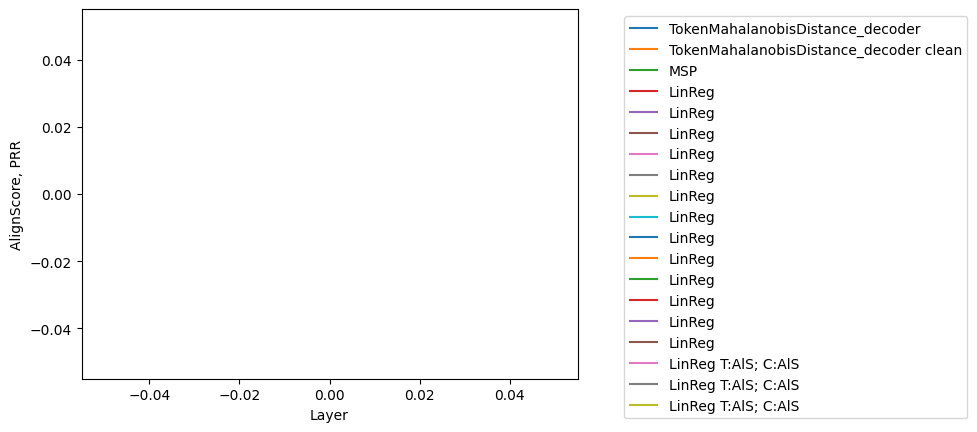

In [1416]:
import matplotlib.pyplot as plt

def check_cond(col, name="TokenMahalanobisDistance_decoder", suf="(mean, , 0)"):
    return (name in col) and (suf in col)
names = ["TokenMahalanobisDistance_decoder"]
suf = "(mean, , 0)"#"(mean, Accuracy, 0.3)"
i = 1
for name in names:
    cols = [x for x in df0.columns if check_cond(x, name, suf)]
    layers = [int(x.split("_")[2].split(" ")[0]) if len(x.split("_")) > 2 else 17 for x in cols]
    plt.plot(layers, df0[cols].values[i], label=name)

suf = "(mean, Accuracy, 0.3)"
for name in names:
    cols = [x for x in df0.columns if check_cond(x, name, suf)]
    layers = [int(x.split("_")[2].split(" ")[0]) if len(x.split("_")) > 2 else 17 for x in cols]
    plt.plot(layers, df0[cols].values[i], label=name + " clean")
    
plt.plot(layers, [df0['MaximumSequenceProbability'][i]]*len(layers), label="MSP")
for c in df0.columns[-16:]:
    if "relative" in c.lower():
        continue
    label = "LinReg"
    if "pos" in c:
        label += " pos."
    if "Accuracy, Accuracy" in c:
        label += " T:Acc; C:Acc"
    if "AlignScore, Accuracy" in c:
        label += " T:AlS; C:Acc"
    if "Accuracy, AlignScore" in c:
        label += " T:Acc; C:AlS"
    if "AlignScore, AlignScore" in c:
        label += " T:AlS; C:AlS"
        
    plt.plot(layers, [df0[c][i]]*len(layers), label=label)

plt.xlabel("Layer")
plt.ylabel("AlignScore, PRR")
plt.legend(loc='upper right', bbox_to_anchor=(1.8, 1))

/tmp/ipykernel_722/3933423135.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(layers, [df0['MaximumSequenceProbability'][i]]*len(layers), label="MSP")
/tmp/ipykernel_722/3933423135.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(layers, [df0[c][i]]*len(layers), label=label)


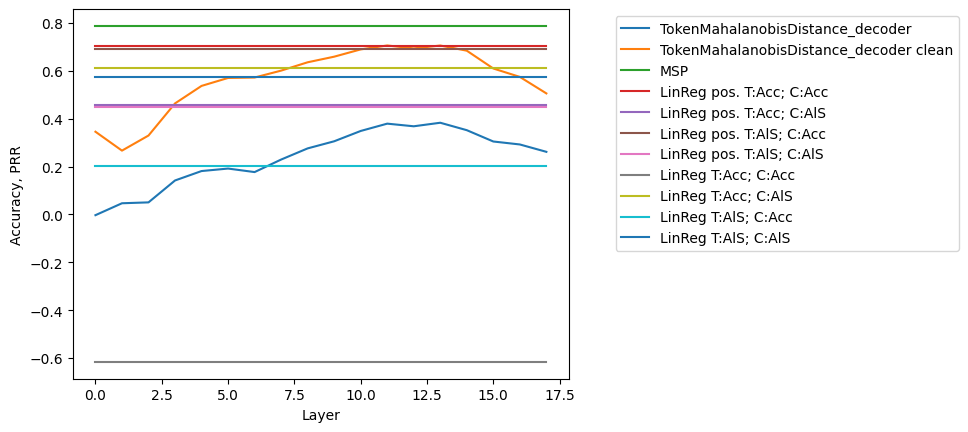

In [827]:
import matplotlib.pyplot as plt

def check_cond(col, name="TokenMahalanobisDistance_decoder", suf="(mean, , 0)"):
    return (name in col) and (suf in col)
names = ["TokenMahalanobisDistance_decoder"]
suf = "(mean, , 0)"#"(mean, Accuracy, 0.3)"
i = 0
for name in names:
    cols = [x for x in df0.columns if check_cond(x, name, suf)]
    layers = [int(x.split("_")[2].split(" ")[0]) if len(x.split("_")) > 2 else 17 for x in cols]
    plt.plot(layers, df0[cols].values[i], label=name)

suf = "(mean, Accuracy, 0.3)"
for name in names:
    cols = [x for x in df0.columns if check_cond(x, name, suf)]
    layers = [int(x.split("_")[2].split(" ")[0]) if len(x.split("_")) > 2 else 17 for x in cols]
    plt.plot(layers, df0[cols].values[i], label=name + " clean")
    
plt.plot(layers, [df0['MaximumSequenceProbability'][i]]*len(layers), label="MSP")
for c in df0.columns[-16:]:
    if "relative" in c.lower():
        continue
    label = "LinReg"
    if "pos" in c:
        label += " pos."
    if "Accuracy, Accuracy" in c:
        label += " T:Acc; C:Acc"
    if "AlignScore, Accuracy" in c:
        label += " T:AlS; C:Acc"
    if "Accuracy, AlignScore" in c:
        label += " T:Acc; C:AlS"
    if "AlignScore, AlignScore" in c:
        label += " T:AlS; C:AlS"
        
    plt.plot(layers, [df0[c][i]]*len(layers), label=label)

plt.xlabel("Layer")
plt.ylabel("Accuracy, PRR")
plt.legend(loc='upper right', bbox_to_anchor=(1.8, 1))

In [783]:
len(man["stats"]["greedy_texts"])

100

In [720]:
path = "../workdir/output_layers/qa/google/gemma-2b/coqa/2024-07-11/11-03-35/ue_manager_seed1"
path = "../workdir/output_layers/qa/google/gemma-2b/['truthful_qa', 'generation']/2024-07-11/11-48-15/ue_manager_seed1"
path = "../workdir/output_layers/ats/google/gemma-2b/samsum/2024-07-11/13-21-44/ue_manager_seed1"
man = torch.load(path)

metric_names = ['Rouge_rougeL', 'AlignScore']
df = {}
for key in man['metrics'].keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man['metrics'][key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'CoQA, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"CoQA, {metric_names[-1]}, PRR", ascending=False).style.background_gradient(axis=0)

,"CoQA, Rouge_rougeL, PRR","CoQA, AlignScore, PRR"
"LinRegTokenMahalanobisDistance_decoder0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,-1 (mean, alignscore, 0.0, )",0.075309,0.133068
MahalanobisDistanceSeq_decoder,0.171722,0.096881
MeanTokenEntropy,-0.060054,0.093614
Perplexity,-0.090630,0.052248
"LinRegTokenMahalanobisDistance_decoder0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,-1 (mean, alignscore, 0.3, )",0.077757,0.040971
"TokenMahalanobisDistance_decoder_2 (mean, AlignScore, 0.3)",0.092972,0.032080
"TokenMahalanobisDistance_decoder_0 (mean, AlignScore, 0.3)",0.082048,0.017065
"TokenMahalanobisDistance_decoder_1 (mean, AlignScore, 0.3)",0.088403,0.002193
"LinRegTokenMahalanobisDistance_decoder0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,-1 (mean, alignscore, 0.3, pos)",0.065364,-0.021651
"TokenMahalanobisDistance_decoder_4 (mean, AlignScore, 0.3)",-0.019798,-0.022339


In [712]:
np.mean(man['gen_metrics'][('sequence', 'Accuracy')])

0.47

/tmp/ipykernel_722/2464449270.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(layers, [df0['MaximumSequenceProbability'][0]]*len(layers), label="MSP")


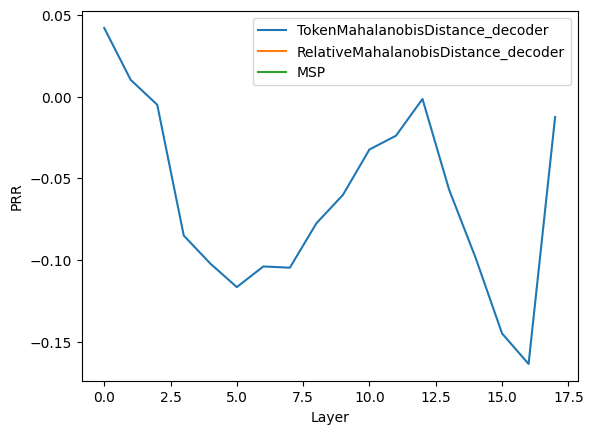

In [719]:
import matplotlib.pyplot as plt

def check_cond(col, name="TokenMahalanobisDistance_decoder", suf="(mean, , 0)"):
    return (name in col) and (suf in col)
names = ["TokenMahalanobisDistance_decoder", "RelativeMahalanobisDistance_decoder"]
for name in names:
    cols = [x for x in df0.columns if check_cond(x, name)]
    layers = [int(x.split("_")[2].split(" ")[0]) if len(x.split("_")) > 2 else 17 for x in cols]
    
    plt.plot(layers, df0[cols].values[0], label=name)
plt.plot(layers, [df0['MaximumSequenceProbability'][0]]*len(layers), label="MSP")
plt.xlabel("Layer")
plt.ylabel("PRR")
plt.legend()

# SciQ

## Vicuna 7b

In [60]:
path = "lm-polygraph/workdir/output/qa/lmsys/vicuna-7b-v1.5/sciq/2024-04-09/22-25-46/ue_manager_seed1"
man = UEManager.load(path)

metric_names = ['Accuracy', 'AlignScore']
df = {}
for key in man.metrics.keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man.metrics[key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'SciQ, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"SciQ, {metric_names[-1]}, PRR", ascending=False).style.background_gradient(axis=0)

Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x7fc48b67cf40>]


,"SciQ, Accuracy, PRR","SciQ, AlignScore, PRR"
"TokenMahalanobisDistance_decoder (mean, alignscore, 0.9)",0.665993,0.584277
"TokenMahalanobisDistance_decoder (mean, alignscore, 0.5)",0.644520,0.566720
"TokenMahalanobisDistance_decoder (mean, accuracy, 1.0)",0.902777,0.564961
"RelativeMahalanobisDistance_decoder (sum, alignscore, 0.9)",0.697955,0.550695
"TokenMahalanobisDistance_decoder (mean, alignscore, 0.0)",0.635907,0.549770
"RelativeMahalanobisDistance_decoder (mean, accuracy, 1.0)",0.905488,0.548268
"RelativeMahalanobisDistance_decoder (mean, alignscore, 0.9)",0.629997,0.534538
"TokenMahalanobisDistance_decoder (sum, alignscore, 0.9)",0.890280,0.507877
"RelativeMahalanobisDistance_decoder (sum, accuracy, 1.0)",0.927680,0.506569
"TokenMahalanobisDistance_decoder (sum, accuracy, 1.0)",0.920234,0.501223


In [54]:
np.mean(man.gen_metrics[('sequence', 'Accuracy')])

0.211

## Vicuna 13b

In [61]:
path = "lm-polygraph/workdir/output/qa/lmsys/vicuna-13b-v1.5/sciq/2024-04-09/22-25-26/ue_manager_seed1"
man = UEManager.load(path)

metric_names = ['Accuracy', 'AlignScore']
df = {}
for key in man.metrics.keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man.metrics[key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'SciQ, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"SciQ, {metric_names[-1]}, PRR", ascending=False).style.background_gradient(axis=0)

Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x7fc48b67cf40>]


,"SciQ, Accuracy, PRR","SciQ, AlignScore, PRR"
"TokenMahalanobisDistance_decoder (mean, alignscore, 0.9)",0.673459,0.698069
"TokenMahalanobisDistance_decoder (mean, accuracy, 1.0)",0.763938,0.687435
"TokenMahalanobisDistance_decoder (mean, alignscore, 0.5)",0.649234,0.681515
"TokenMahalanobisDistance_decoder (mean, alignscore, 0.0)",0.637699,0.670883
"RelativeMahalanobisDistance_decoder (mean, alignscore, 0.9)",0.701557,0.658282
"RelativeMahalanobisDistance_decoder (mean, accuracy, 1.0)",0.770314,0.655360
"RelativeMahalanobisDistance_decoder (sum, alignscore, 0.9)",0.717094,0.637501
"RelativeMahalanobisDistance_decoder (mean, alignscore, 0.5)",0.678222,0.630164
"RelativeMahalanobisDistance_decoder (sum, accuracy, 1.0)",0.787178,0.626080
"RelativeMahalanobisDistance_decoder (sum, alignscore, 0.5)",0.650041,0.603264


In [62]:
np.mean(man.gen_metrics[('sequence', 'Accuracy')])

0.518

## Mistral 7b

In [124]:
path = "lm-polygraph/workdir/output/qa/alpindale/Mistral-7B-v0.2-hf/sciq/2024-04-10/05-00-23/ue_manager_seed1"
man = UEManager.load(path)

metric_names = ['Accuracy', 'AlignScore']
df = {}
for key in man.metrics.keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man.metrics[key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'SciQ, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"SciQ, {metric_names[-1]}, PRR", ascending=False).style.background_gradient(axis=0)

Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x7fc48b67cf40>]


,"SciQ, Accuracy, PRR","SciQ, AlignScore, PRR"
"TokenMahalanobisDistance_decoder (sum, alignscore, 0.9)",-0.265819,0.428868
"TokenMahalanobisDistance_decoder (mean, alignscore, 0.9)",-0.331701,0.414744
"TokenMahalanobisDistance_decoder (sum, alignscore, 0.5)",-0.259495,0.406263
"RelativeMahalanobisDistance_decoder (sum, alignscore, 0.9)",-0.326745,0.393589
"TokenMahalanobisDistance_decoder (mean, alignscore, 0.5)",-0.325507,0.391920
"RelativeMahalanobisDistance_decoder (mean, alignscore, 0.9)",-0.331136,0.390634
"TokenMahalanobisDistance_decoder (sum, alignscore, 0.0)",-0.257455,0.383041
"RelativeMahalanobisDistance_decoder (sum, alignscore, 0.5)",-0.321503,0.374006
"RelativeMahalanobisDistance_decoder (mean, alignscore, 0.5)",-0.325209,0.371871
"TokenMahalanobisDistance_decoder (mean, alignscore, 0.0)",-0.323484,0.368324


In [64]:
np.mean(man.gen_metrics[('sequence', 'Accuracy')])

0.146

## LLama 3 8b

In [173]:
path = "../workdir/output/qa/meta-llama/Meta-Llama-3-8B/sciq/2024-07-03/15-43-35/ue_manager_seed1"
man = torch.load(path)

metric_names = ['Accuracy', 'AlignScore']
df = {}
for key in man['metrics'].keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man["metrics"][key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'SciQ, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"SciQ, {metric_names[-1]}, PRR", ascending=False).style.background_gradient(axis=0)

,"SciQ, Accuracy, PRR","SciQ, AlignScore, PRR"
"TokenMahalanobisDistance_decoder_15 (mean, alignscore, 0.5)",0.656779,0.682918
"RelativeMahalanobisDistance_decoder_15 (mean, alignscore, 0.5)",0.741308,0.669649
"TokenMahalanobisDistance_decoder_20 (mean, accuracy, 0.5)",0.774533,0.648189
"TokenMahalanobisDistance_decoder_20 (mean, alignscore, 0.5)",0.529574,0.643430
"RelativeMahalanobisDistance_decoder_10 (mean, alignscore, 0.5)",0.700582,0.627879
"TokenMahalanobisDistance_decoder_10 (mean, alignscore, 0.5)",0.631883,0.625409
"TokenMahalanobisDistance_decoder_25 (mean, accuracy, 0.5)",0.737451,0.616303
"TokenMahalanobisDistance_decoder_15 (mean, accuracy, 0.5)",0.839331,0.615493
"TokenMahalanobisDistance_decoder_10 (mean, accuracy, 0.5)",0.805607,0.606805
MaximumSequenceProbability,0.670542,0.595448


In [174]:
np.mean(man['gen_metrics'][('sequence', 'Accuracy')])

0.395

/tmp/ipykernel_45993/1744307022.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(layers, [df0['MaximumSequenceProbability'][0]]*len(layers), label="MSP")


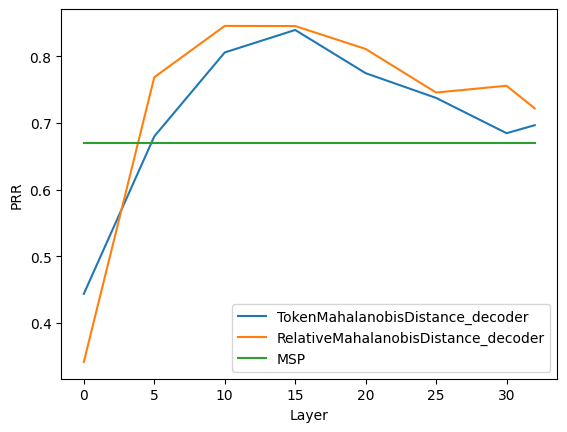

In [175]:
import matplotlib.pyplot as plt

def check_cond(col, name="TokenMahalanobisDistance_decoder", suf="(mean, accuracy, 0.5)"):
    return (name in col) and (suf in col)
names = ["TokenMahalanobisDistance_decoder", "RelativeMahalanobisDistance_decoder"]
for name in names:
    cols = [x for x in df0.columns if check_cond(x, name)]
    layers = [int(x.split("_")[2].split(" ")[0]) if len(x.split("_")) > 2 else 32 for x in cols]
    
    plt.plot(layers, df0[cols].values[0], label=name)
plt.plot(layers, [df0['MaximumSequenceProbability'][0]]*len(layers), label="MSP")
plt.xlabel("Layer")
plt.ylabel("PRR")
plt.legend()

## Gemma 7b

In [100]:
path = "../workdir/output/qa/google/gemma-7b/sciq/2024-07-03/22-16-46/ue_manager_seed1"
man = torch.load(path)

metric_names = ['Accuracy', 'AlignScore']
df = {}
for key in man['metrics'].keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man["metrics"][key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'SciQ, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"SciQ, {metric_names[-1]}, PRR", ascending=False).style.background_gradient(axis=0)

,"SciQ, Accuracy, PRR","SciQ, AlignScore, PRR"
MaximumSequenceProbability,0.805579,0.680259
"RelativeMahalanobisDistance_decoder_20 (mean, AlignScore, 0.9)",0.644656,0.668175
"TokenMahalanobisDistance_decoder_20 (mean, AlignScore, 0.9)",0.639502,0.663961
"RelativeMahalanobisDistance_decoder_20 (mean, AlignScore, 0.6)",0.627996,0.663506
"TokenMahalanobisDistance_decoder_20 (mean, AlignScore, 0.6)",0.615628,0.657833
"RelativeMahalanobisDistance_decoder_20 (mean, AlignScore, 0.3)",0.624835,0.655093
"RelativeMahalanobisDistance_decoder_20 (mean, Rouge-L, 0.3)",0.634008,0.654124
"RelativeMahalanobisDistance_decoder_20 (mean, Rouge-L, 0.6)",0.646858,0.652497
"TokenMahalanobisDistance_decoder_20 (mean, AlignScore, 0.3)",0.612940,0.651092
"RelativeMahalanobisDistance_decoder_20 (mean, Rouge-L, 0.9)",0.718926,0.650226


In [5]:
np.mean(man['gen_metrics'][('sequence', 'Accuracy')])

0.549

/tmp/ipykernel_45993/3417078518.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(layers, [df0['MaximumSequenceProbability'][0]]*len(layers), label="MSP")


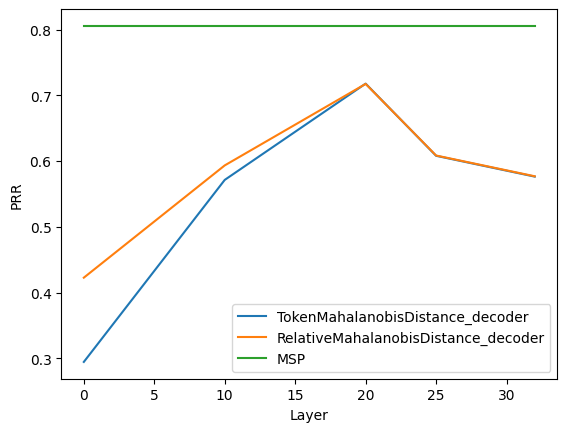

In [102]:
import matplotlib.pyplot as plt

def check_cond(col, name="TokenMahalanobisDistance_decoder", suf="(mean, Accuracy, 0.3)"):
    return (name in col) and (suf in col)
names = ["TokenMahalanobisDistance_decoder", "RelativeMahalanobisDistance_decoder"]
for name in names:
    cols = [x for x in df0.columns if check_cond(x, name)]
    layers = [int(x.split("_")[2].split(" ")[0]) if len(x.split("_")) > 2 else 32 for x in cols]
    
    plt.plot(layers, df0[cols].values[0], label=name)
plt.plot(layers, [df0['MaximumSequenceProbability'][0]]*len(layers), label="MSP")
plt.xlabel("Layer")
plt.ylabel("PRR")
plt.legend()

# TriviaQA

## Vicuna 7b

In [65]:
path = "lm-polygraph/workdir/output/qa/lmsys/vicuna-7b-v1.5/['trivia_qa', 'rc.nocontext']/2024-04-09/22-25-24/ue_manager_seed1"
man = UEManager.load(path)

metric_names = ['Accuracy', 'AlignScore']
df = {}
for key in man.metrics.keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man.metrics[key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'TriviaQA, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"TriviaQA, {metric_names[-1]}, PRR", ascending=False).style.background_gradient(axis=0)

Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x7fc48b67cf40>]


,"TriviaQA, Accuracy, PRR","TriviaQA, AlignScore, PRR"
MaximumSequenceProbability,0.547689,0.572455
"TokenMahalanobisDistance_decoder (sum, alignscore, 0.9)",0.581011,0.420545
"TokenMahalanobisDistance_decoder (sum, alignscore, 0.5)",0.577732,0.416744
"TokenMahalanobisDistance_decoder (sum, accuracy, 1.0)",0.595045,0.413152
"TokenMahalanobisDistance_decoder (sum, alignscore, 0.0)",0.563798,0.398236
"TokenMahalanobisDistance_decoder (mean, alignscore, 0.9)",0.438955,0.334290
MeanTokenEntropy,0.127140,0.329241
"TokenMahalanobisDistance_decoder (mean, accuracy, 1.0)",0.516962,0.328341
"TokenMahalanobisDistance_decoder (mean, alignscore, 0.5)",0.428726,0.324810
"RelativeMahalanobisDistance_decoder (sum, accuracy, 1.0)",0.542539,0.318825


In [66]:
np.mean(man.gen_metrics[('sequence', 'Accuracy')])

0.335

## Vicuna 13b

In [67]:
path = "lm-polygraph/workdir/output/qa/lmsys/vicuna-13b-v1.5/['trivia_qa', 'rc.nocontext']/2024-04-09/22-25-24/ue_manager_seed1"
man = UEManager.load(path)

metric_names = ['Accuracy', 'AlignScore']
df = {}
for key in man.metrics.keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man.metrics[key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'TriviaQA, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"TriviaQA, {metric_names[-1]}, PRR", ascending=False).style.background_gradient(axis=0)

Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x7fc48b67cf40>]


,"TriviaQA, Accuracy, PRR","TriviaQA, AlignScore, PRR"
MaximumSequenceProbability,0.649271,0.596263
MeanTokenEntropy,0.473291,0.581673
Perplexity,0.493253,0.548530
"TokenMahalanobisDistance_decoder (mean, alignscore, 0.9)",0.490199,0.410863
"TokenMahalanobisDistance_decoder (mean, alignscore, 0.5)",0.483249,0.400115
"TokenMahalanobisDistance_decoder (mean, accuracy, 1.0)",0.541686,0.382376
"RelativeMahalanobisDistance_decoder (sum, alignscore, 0.9)",0.466970,0.341137
"RelativeMahalanobisDistance_decoder (sum, accuracy, 1.0)",0.538213,0.331156
"RelativeMahalanobisDistance_decoder (mean, alignscore, 0.9)",0.438831,0.329843
"RelativeMahalanobisDistance_decoder (mean, accuracy, 1.0)",0.509496,0.313983


In [68]:
np.mean(man.gen_metrics[('sequence', 'Accuracy')])

0.528

## Mistral 7b

In [126]:
path = "lm-polygraph/workdir/output/qa/alpindale/Mistral-7B-v0.2-hf/['trivia_qa', 'rc.nocontext']/2024-04-10/05-00-05/ue_manager_seed1"
man = UEManager.load(path)

metric_names = ['Accuracy', 'AlignScore']
df = {}
for key in man.metrics.keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man.metrics[key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'TriviaQA, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"TriviaQA, {metric_names[-1]}, PRR", ascending=False).style.background_gradient(axis=0)

Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x7fc48b67cf40>]


,"TriviaQA, Accuracy, PRR","TriviaQA, AlignScore, PRR"
MeanTokenEntropy,0.088757,0.269215
MaximumSequenceProbability,0.069616,0.258446
Perplexity,0.069616,0.258446
"TokenMahalanobisDistance_decoder (mean, alignscore, 0.9)",0.344637,0.138475
"TokenMahalanobisDistance_decoder (sum, alignscore, 0.9)",0.344637,0.138475
"TokenMahalanobisDistance_decoder (sum, alignscore, 0.5)",0.377890,0.130340
"TokenMahalanobisDistance_decoder (mean, alignscore, 0.5)",0.377890,0.130340
"TokenMahalanobisDistance_decoder (mean, accuracy, 1.0)",0.398288,0.118540
"TokenMahalanobisDistance_decoder (sum, accuracy, 1.0)",0.398288,0.118540
"RelativeMahalanobisDistance_decoder (sum, alignscore, 0.9)",0.347659,0.115769


In [127]:
np.mean(man.gen_metrics[('sequence', 'Accuracy')])

0.558

## Gemma

In [107]:
path = "../workdir/output/qa/google/gemma-7b/['trivia_qa', 'rc.nocontext']/2024-07-04/01-41-50/ue_manager_seed1"
man = torch.load(path)

metric_names = ['Accuracy', 'AlignScore']
df = {}
for key in man['metrics'].keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man["metrics"][key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'SciQ, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"SciQ, {metric_names[-1]}, PRR", ascending=False).style.background_gradient(axis=0)

,"SciQ, Accuracy, PRR","SciQ, AlignScore, PRR"
MaximumSequenceProbability,0.830297,0.786661
Perplexity,0.822510,0.782402
MeanTokenEntropy,0.805005,0.777207
"TokenMahalanobisDistance_decoder (mean, Accuracy, 0.3)",0.409310,0.418304
"TokenMahalanobisDistance_decoder (mean, Accuracy, 0.9)",0.409310,0.418304
"TokenMahalanobisDistance_decoder (mean, Accuracy, 0.6)",0.409310,0.418304
"TokenMahalanobisDistance_decoder (mean, AlignScore, 0.9)",0.407561,0.417829
"TokenMahalanobisDistance_decoder (mean, Rouge-L, 0.9)",0.412654,0.416316
"TokenMahalanobisDistance_decoder (mean, Rouge-L, 0.6)",0.408712,0.412815
"TokenMahalanobisDistance_decoder (mean, AlignScore, 0.6)",0.397106,0.409786


/tmp/ipykernel_45993/806350166.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(layers, [df0['MaximumSequenceProbability'][0]]*len(layers), label="MSP")


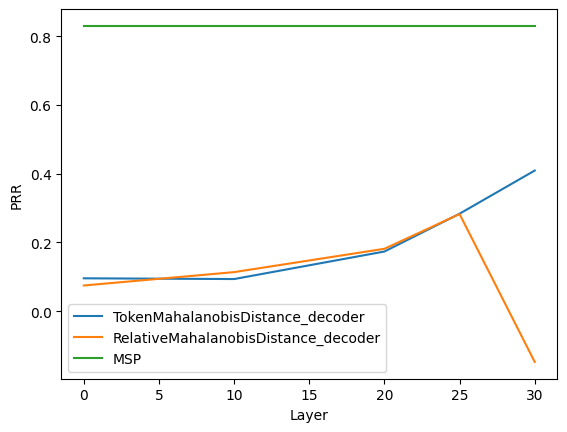

In [110]:
import matplotlib.pyplot as plt

def check_cond(col, name="TokenMahalanobisDistance_decoder", suf="(mean, Accuracy, 0.3)"):
    return (name in col) and (suf in col)
names = ["TokenMahalanobisDistance_decoder", "RelativeMahalanobisDistance_decoder"]
for name in names:
    cols = [x for x in df0.columns if check_cond(x, name)]
    layers = [int(x.split("_")[2].split(" ")[0]) if len(x.split("_")) > 2 else 30 for x in cols]
    
    plt.plot(layers, df0[cols].values[0], label=name)
plt.plot(layers, [df0['MaximumSequenceProbability'][0]]*len(layers), label="MSP")
plt.xlabel("Layer")
plt.ylabel("PRR")
plt.legend()

In [14]:
np.mean(man['gen_metrics'][('sequence', 'Accuracy')])

0.551

# MMLU

## Vicuna 7b

In [74]:
path = "lm-polygraph/workdir/output/qa/lmsys/vicuna-7b-v1.5/['cais/mmlu', 'all']/2024-04-09/22-25-26/ue_manager_seed1"
man = UEManager.load(path)

metric_names = ['Accuracy']
df = {}
for key in man.metrics.keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man.metrics[key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'MMLU, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"MMLU, {metric_names[-1]}, PRR", ascending=False).style.background_gradient(axis=0)

Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x7fc48b67cf40>]


,"MMLU, Accuracy, PRR"
MeanTokenEntropy,0.474275
MaximumSequenceProbability,0.449569
Perplexity,0.449569
"TokenMahalanobisDistance_decoder (mean, alignscore, 0.5)",0.250325
"TokenMahalanobisDistance_decoder (sum, alignscore, 0.5)",0.250325
"RelativeMahalanobisDistance_decoder (sum, alignscore, 0.5)",0.248022
"RelativeMahalanobisDistance_decoder (mean, alignscore, 0.5)",0.248022
"TokenMahalanobisDistance_decoder (sum, alignscore, 0.0)",0.220600
"TokenMahalanobisDistance_decoder (mean, alignscore, 0.0)",0.220600
"RelativeMahalanobisDistance_decoder (mean, alignscore, 0.0)",0.219658


In [75]:
np.mean(man.gen_metrics[('sequence', 'Accuracy')])

0.403

## Vicuna 13b

In [76]:
path = "lm-polygraph/workdir/output/qa/lmsys/vicuna-13b-v1.5/['cais/mmlu', 'all']/2024-04-09/22-25-26/ue_manager_seed1"
man = UEManager.load(path)

metric_names = ['Accuracy']
df = {}
for key in man.metrics.keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man.metrics[key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'MMLU, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"MMLU, {metric_names[-1]}, PRR", ascending=False).style.background_gradient(axis=0)

Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x7fc48b67cf40>]


,"MMLU, Accuracy, PRR"
MeanTokenEntropy,0.653613
MaximumSequenceProbability,0.642444
Perplexity,0.642444
"TokenMahalanobisDistance_decoder (mean, alignscore, 0.0)",0.160387
"TokenMahalanobisDistance_decoder (sum, alignscore, 0.0)",0.160387
"RelativeMahalanobisDistance_decoder (sum, alignscore, 0.0)",0.158379
"RelativeMahalanobisDistance_decoder (mean, alignscore, 0.0)",0.158379
"TokenMahalanobisDistance_decoder (mean, alignscore, 0.5)",0.127214
"TokenMahalanobisDistance_decoder (sum, alignscore, 0.5)",0.127214
"RelativeMahalanobisDistance_decoder (sum, alignscore, 0.5)",0.127011


In [77]:
np.mean(man.gen_metrics[('sequence', 'Accuracy')])

0.4865

## Mistral 7b

In [129]:
path = "lm-polygraph/workdir/output/qa/alpindale/Mistral-7B-v0.2-hf/['cais/mmlu', 'all']/2024-04-10/05-00-23/ue_manager_seed1"
man = UEManager.load(path)

metric_names = ['Accuracy']
df = {}
for key in man.metrics.keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man.metrics[key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'MMLU, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"MMLU, {metric_names[-1]}, PRR", ascending=False).style.background_gradient(axis=0)

Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x7fc48b67cf40>]


,"MMLU, Accuracy, PRR"
MeanTokenEntropy,0.695688
MaximumSequenceProbability,0.678909
Perplexity,0.678909
"TokenMahalanobisDistance_decoder (mean, alignscore, 0.5)",0.151506
"TokenMahalanobisDistance_decoder (sum, alignscore, 0.5)",0.151506
"RelativeMahalanobisDistance_decoder (sum, alignscore, 0.5)",0.150787
"RelativeMahalanobisDistance_decoder (mean, alignscore, 0.5)",0.150787
"TokenMahalanobisDistance_decoder (mean, accuracy, 1.0)",0.111301
"TokenMahalanobisDistance_decoder (sum, accuracy, 1.0)",0.111301
"TokenMahalanobisDistance_decoder (sum, alignscore, 0.9)",0.111301


In [79]:
np.mean(man.gen_metrics[('sequence', 'Accuracy')])

0.5575

# GSM8k

## Vicuna 7b

In [80]:
path = "lm-polygraph/workdir/output/qa/lmsys/vicuna-7b-v1.5/['gsm8k', 'main']/2024-04-09/23-14-31/ue_manager_seed1"
man = UEManager.load(path)

metric_names = ['Accuracy']
df = {}
for key in man.metrics.keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man.metrics[key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'GSM8k, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"GSM8k, {metric_names[-1]}, PRR", ascending=False).style.background_gradient(axis=0)

Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x7fc48b67cf40>]


,"GSM8k, Accuracy, PRR"
"RelativeMahalanobisDistance_decoder (sum, accuracy, 1.0)",0.457930
"TokenMahalanobisDistance_decoder (mean, accuracy, 1.0)",0.448746
"TokenMahalanobisDistance_decoder (mean, alignscore, 0.9)",0.431895
"RelativeMahalanobisDistance_decoder (mean, accuracy, 1.0)",0.430294
"TokenMahalanobisDistance_decoder (mean, alignscore, 0.5)",0.425684
"RelativeMahalanobisDistance_decoder (mean, alignscore, 0.9)",0.412565
"TokenMahalanobisDistance_decoder (mean, alignscore, 0.0)",0.411843
MaximumSequenceProbability,0.372873
"RelativeMahalanobisDistance_decoder (mean, alignscore, 0.5)",0.360804
"RelativeMahalanobisDistance_decoder (mean, alignscore, 0.0)",0.339123


In [81]:
np.mean(man.gen_metrics[('sequence', 'Accuracy')])

0.129

## Vicuna 13b

In [82]:
path = "lm-polygraph/workdir/output/qa/lmsys/vicuna-13b-v1.5/['gsm8k', 'main']/2024-04-09/23-14-30/ue_manager_seed1"
man = UEManager.load(path)

metric_names = ['Accuracy']
df = {}
for key in man.metrics.keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man.metrics[key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'GSM8k, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"GSM8k, {metric_names[-1]}, PRR", ascending=False).style.background_gradient(axis=0)

Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x7fc48b67cf40>]


,"GSM8k, Accuracy, PRR"
"TokenMahalanobisDistance_decoder (mean, accuracy, 1.0)",0.581796
"RelativeMahalanobisDistance_decoder (sum, alignscore, 0.9)",0.542334
"RelativeMahalanobisDistance_decoder (mean, accuracy, 1.0)",0.531925
"TokenMahalanobisDistance_decoder (mean, alignscore, 0.5)",0.528363
"RelativeMahalanobisDistance_decoder (sum, accuracy, 1.0)",0.522828
"TokenMahalanobisDistance_decoder (mean, alignscore, 0.0)",0.518332
"TokenMahalanobisDistance_decoder (sum, accuracy, 1.0)",0.509051
"TokenMahalanobisDistance_decoder (sum, alignscore, 0.9)",0.502940
"TokenMahalanobisDistance_decoder (sum, alignscore, 0.5)",0.492718
"TokenMahalanobisDistance_decoder (mean, alignscore, 0.9)",0.486378


In [83]:
np.mean(man.gen_metrics[('sequence', 'Accuracy')])

0.191

## Mistral 7b

In [131]:
path = "lm-polygraph/workdir/output/qa/alpindale/Mistral-7B-v0.2-hf/['gsm8k', 'main']/2024-04-09/23-14-29/ue_manager_seed1"
man = UEManager.load(path)

metric_names = ['Accuracy']
df = {}
for key in man.metrics.keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man.metrics[key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'GSM8k, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"GSM8k, {metric_names[-1]}, PRR", ascending=False).style.background_gradient(axis=0)

Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x7fc48b67cf40>]


,"GSM8k, Accuracy, PRR"
"TokenMahalanobisDistance_decoder (mean, accuracy, 1.0)",0.319444
"TokenMahalanobisDistance_decoder (sum, accuracy, 1.0)",0.319444
"TokenMahalanobisDistance_decoder (mean, alignscore, 0.5)",0.310199
"TokenMahalanobisDistance_decoder (sum, alignscore, 0.5)",0.310199
"RelativeMahalanobisDistance_decoder (sum, accuracy, 1.0)",0.307177
"RelativeMahalanobisDistance_decoder (mean, accuracy, 1.0)",0.307177
"RelativeMahalanobisDistance_decoder (sum, alignscore, 0.5)",0.299965
"RelativeMahalanobisDistance_decoder (mean, alignscore, 0.5)",0.299965
"TokenMahalanobisDistance_decoder (sum, alignscore, 0.0)",0.287797
"TokenMahalanobisDistance_decoder (mean, alignscore, 0.0)",0.287797


In [85]:
np.mean(man.gen_metrics[('sequence', 'Accuracy')])

0.323

## Gemma 7b

In [156]:
path = "../workdir/output/qa/google/gemma-7b/['gsm8k', 'main']/2024-07-03/18-32-16/ue_manager_seed1"
man = torch.load(path)

metric_names = ['Accuracy', 'AlignScore']
df = {}
for key in man['metrics'].keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man["metrics"][key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'SciQ, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"SciQ, {metric_names[-2]}, PRR", ascending=False).style.background_gradient(axis=0)

,"SciQ, Accuracy, PRR","SciQ, AlignScore, PRR"
"TokenMahalanobisDistance_decoder_20 (mean, Accuracy, 0.3)",0.605299,0.325393
"TokenMahalanobisDistance_decoder_20 (mean, Rouge-L, 0.3)",0.579619,0.309603
"TokenMahalanobisDistance_decoder_20 (mean, AlignScore, 0.3)",0.558837,0.308469
"RelativeMahalanobisDistance_decoder_20 (mean, Accuracy, 0.3)",0.548609,0.219331
"TokenMahalanobisDistance_decoder_25 (mean, Accuracy, 0.3)",0.547615,0.316009
"TokenMahalanobisDistance_decoder_20 (mean, , 0)",0.537361,0.282027
"TokenMahalanobisDistance_decoder (mean, Accuracy, 0.3)",0.535684,0.295627
"TokenMahalanobisDistance_decoder_25 (mean, Rouge-L, 0.3)",0.528034,0.309057
"TokenMahalanobisDistance_decoder (mean, Rouge-L, 0.3)",0.521782,0.292749
"RelativeMahalanobisDistance_decoder_20 (mean, Rouge-L, 0.3)",0.516010,0.198060


/tmp/ipykernel_45993/3417078518.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(layers, [df0['MaximumSequenceProbability'][0]]*len(layers), label="MSP")


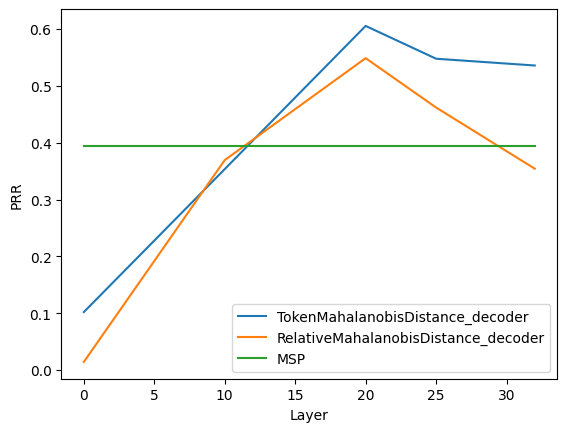

In [157]:
import matplotlib.pyplot as plt

def check_cond(col, name="TokenMahalanobisDistance_decoder", suf="(mean, Accuracy, 0.3)"):
    return (name in col) and (suf in col)
names = ["TokenMahalanobisDistance_decoder", "RelativeMahalanobisDistance_decoder"]
for name in names:
    cols = [x for x in df0.columns if check_cond(x, name)]
    layers = [int(x.split("_")[2].split(" ")[0]) if len(x.split("_")) > 2 else 32 for x in cols]
    
    plt.plot(layers, df0[cols].values[0], label=name)
plt.plot(layers, [df0['MaximumSequenceProbability'][0]]*len(layers), label="MSP")
plt.xlabel("Layer")
plt.ylabel("PRR")
plt.legend()

In [158]:
np.mean(man['gen_metrics'][('sequence', 'Accuracy')])

0.568

## Llama 3

In [6]:
path = "../workdir/output_layers/qa/meta-llama/Meta-Llama-3-8B/['gsm8k', 'main']/2024-07-09/10-13-16/ue_manager_seed1"
man = torch.load(path)
metric_names = ['Accuracy']
df = {}
for key in man['metrics'].keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man["metrics"][key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'SciQ, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"SciQ, {metric_names[-1]}, PRR", ascending=False).style.background_gradient(axis=0)

,"SciQ, Accuracy, PRR"
MaximumSequenceProbability,0.717325
Perplexity,0.717325
MeanTokenEntropy,0.642937
MahalanobisDistanceSeq_decoder,0.352469
"TokenMahalanobisDistance_decoder (mean, , 0)",0.097424
"TokenMahalanobisDistance_decoder (mean, Accuracy, 0.3)",0.097424
"TokenMahalanobisDistance_decoder (mean, AlignScore, 0.3)",0.097424
"RelativeMahalanobisDistance_decoder (mean, Accuracy, 0.3)",-0.225279
"RelativeMahalanobisDistance_decoder (mean, AlignScore, 0.3)",-0.225279
"RelativeMahalanobisDistance_decoder (mean, , 0)",-0.267787


In [8]:
man["estimations"][('sequence', 'TokenMahalanobisDistance_decoder (mean, , 0)')]

[1709.782958984375,
 1588.97314453125,
 1667.5653076171875,
 1943.2642822265625,
 1752.0635986328125,
 1769.36669921875,
 1841.2806396484375,
 1886.8526611328125,
 1250.525634765625,
 1611.755859375]

In [159]:
path = "../workdir/output/qa/meta-llama/Meta-Llama-3-8B/['gsm8k', 'main']/2024-07-04/04-09-02/ue_manager_seed1"
man = torch.load(path)
metric_names = ['Accuracy']
df = {}
for key in man['metrics'].keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man["metrics"][key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'SciQ, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"SciQ, {metric_names[-1]}, PRR", ascending=False).style.background_gradient(axis=0)

,"SciQ, Accuracy, PRR"
"TokenMahalanobisDistance_decoder_20 (mean, Accuracy, 0.3)",0.585455
"RelativeMahalanobisDistance_decoder_20 (mean, Accuracy, 0.3)",0.571641
"TokenMahalanobisDistance_decoder_20 (mean, Rouge-L, 0.3)",0.559192
"TokenMahalanobisDistance_decoder_20 (mean, AlignScore, 0.3)",0.553778
"RelativeMahalanobisDistance_decoder_20 (mean, Rouge-L, 0.3)",0.544608
"RelativeMahalanobisDistance_decoder_20 (mean, AlignScore, 0.3)",0.541879
"TokenMahalanobisDistance_decoder_20 (mean, , 0)",0.540727
"RelativeMahalanobisDistance_decoder_20 (mean, , 0)",0.525735
"RelativeMahalanobisDistance_decoder_30 (mean, Accuracy, 0.3)",0.515524
"TokenMahalanobisDistance_decoder (mean, Accuracy, 0.3)",0.514192


/tmp/ipykernel_45993/3417078518.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(layers, [df0['MaximumSequenceProbability'][0]]*len(layers), label="MSP")


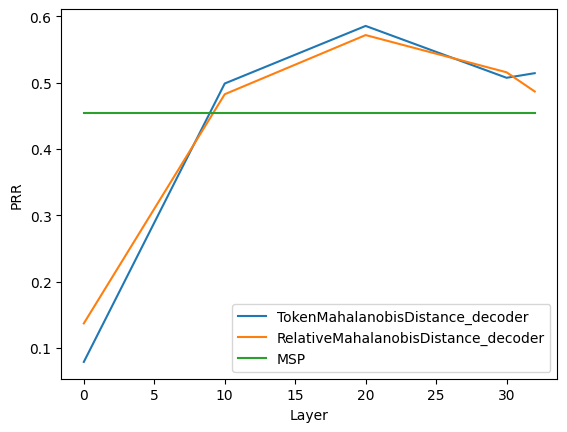

In [160]:
import matplotlib.pyplot as plt

def check_cond(col, name="TokenMahalanobisDistance_decoder", suf="(mean, Accuracy, 0.3)"):
    return (name in col) and (suf in col)
names = ["TokenMahalanobisDistance_decoder", "RelativeMahalanobisDistance_decoder"]
for name in names:
    cols = [x for x in df0.columns if check_cond(x, name)]
    layers = [int(x.split("_")[2].split(" ")[0]) if len(x.split("_")) > 2 else 32 for x in cols]
    
    plt.plot(layers, df0[cols].values[0], label=name)
plt.plot(layers, [df0['MaximumSequenceProbability'][0]]*len(layers), label="MSP")
plt.xlabel("Layer")
plt.ylabel("PRR")
plt.legend()

In [93]:
np.mean(man['gen_metrics'][('sequence', 'Accuracy')])

0.536

# XSUM

## Vicuna 7b

In [87]:
path = "lm-polygraph/workdir/output/ats/lmsys/vicuna-7b-v1.5/xsum/2024-04-09/23-14-30/ue_manager_seed1"
man = UEManager.load(path)

metric_names = ['Rouge_rougeL', 'AlignScore']
df = {}
for key in man.metrics.keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man.metrics[key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'XSUM, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"XSUM, {metric_names[-1]}, PRR", ascending=False).style.background_gradient(axis=0)

Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x7fc48b67cf40>]


,"XSUM, Rouge_rougeL, PRR","XSUM, AlignScore, PRR"
MeanTokenEntropy,0.024997,0.148440
"TokenMahalanobisDistance_decoder (mean, alignscore, 0.5)",0.075167,0.109446
"RelativeMahalanobisDistance_decoder (mean, alignscore, 0.5)",0.126173,0.109117
Perplexity,0.017226,0.090535
"RelativeMahalanobisDistance_decoder (sum, alignscore, 0.0)",0.040631,0.020652
MaximumSequenceProbability,-0.009734,0.019434
"TokenMahalanobisDistance_decoder (mean, alignscore, 0.0)",-0.055818,0.000061
"RelativeMahalanobisDistance_decoder (sum, alignscore, 0.5)",0.062274,-0.038587
"RelativeMahalanobisDistance_decoder (mean, alignscore, 0.0)",0.067524,-0.050990
"TokenMahalanobisDistance_decoder (sum, alignscore, 0.5)",0.037828,-0.059794


In [88]:
np.mean(man.gen_metrics[('sequence', 'AlignScore')])

0.0621609894928406

## Vicuna 13b

In [89]:
path = "lm-polygraph/workdir/output/ats/lmsys/vicuna-13b-v1.5/xsum/2024-04-09/23-14-29/ue_manager_seed1"
man = UEManager.load(path)

metric_names = ['Rouge_rougeL', 'AlignScore']
df = {}
for key in man.metrics.keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man.metrics[key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'XSUM, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"XSUM, {metric_names[-1]}, PRR", ascending=False).style.background_gradient(axis=0)

Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x7fc48b67cf40>]


,"XSUM, Rouge_rougeL, PRR","XSUM, AlignScore, PRR"
"TokenMahalanobisDistance_decoder (mean, alignscore, 0.5)",0.127219,0.187453
"RelativeMahalanobisDistance_decoder (mean, alignscore, 0.5)",0.160918,0.167808
MeanTokenEntropy,0.088062,0.151454
Perplexity,0.084116,0.135020
MaximumSequenceProbability,0.135675,0.120805
"TokenMahalanobisDistance_decoder (mean, alignscore, 0.0)",0.085816,0.112239
"RelativeMahalanobisDistance_decoder (sum, alignscore, 0.5)",0.173773,0.081399
"TokenMahalanobisDistance_decoder (sum, alignscore, 0.5)",0.159304,0.056370
"TokenMahalanobisDistance_decoder (sum, alignscore, 0.0)",0.144362,0.023399
"RelativeMahalanobisDistance_decoder (sum, alignscore, 0.0)",0.052968,-0.013338


In [90]:
np.mean(man.gen_metrics[('sequence', 'AlignScore')])

0.08629431277797267

## Mistral 7b

In [133]:
path = "lm-polygraph/workdir/output/ats/alpindale/Mistral-7B-v0.2-hf/xsum/2024-04-09/23-14-31/ue_manager_seed1"
man = UEManager.load(path)

metric_names = ['Rouge_rougeL', 'AlignScore']
df = {}
for key in man.metrics.keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man.metrics[key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'XSUM, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"XSUM, {metric_names[-1]}, PRR", ascending=False).style.background_gradient(axis=0)

Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x7fc48b67cf40>]


,"XSUM, Rouge_rougeL, PRR","XSUM, AlignScore, PRR"
"RelativeMahalanobisDistance_decoder (sum, alignscore, 0.5)",0.334371,0.103817
"TokenMahalanobisDistance_decoder (sum, alignscore, 0.5)",0.347345,0.080410
"TokenMahalanobisDistance_decoder (mean, alignscore, 0.5)",-0.194326,0.067441
"RelativeMahalanobisDistance_decoder (mean, alignscore, 0.5)",-0.189549,0.066426
"TokenMahalanobisDistance_decoder (sum, alignscore, 0.0)",0.365192,0.014786
Perplexity,-0.295978,0.013115
MeanTokenEntropy,-0.274470,0.009041
MaximumSequenceProbability,-0.092869,-0.001631
"TokenMahalanobisDistance_decoder (mean, alignscore, 0.0)",-0.213619,-0.019585
"RelativeMahalanobisDistance_decoder (mean, alignscore, 0.0)",-0.019231,-0.020377


In [134]:
np.mean(man.gen_metrics[('sequence', 'AlignScore')]), np.mean(man.gen_metrics[('sequence', 'Rouge_rougeL')])

(0.034991165048508265, 0.20618126565166967)

## Stablm 12b

In [136]:
path = "lm-polygraph/workdir/output/ats/stabilityai/stablelm-2-12b/xsum/2024-04-10/05-39-18/ue_manager_seed1"
man = UEManager.load(path)

metric_names = ['Rouge_rougeL', 'AlignScore']
df = {}
for key in man.metrics.keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man.metrics[key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'XSUM, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"XSUM, {metric_names[-1]}, PRR", ascending=False).style.background_gradient(axis=0)

Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x7fc48b67cf40>]


,"XSUM, Rouge_rougeL, PRR","XSUM, AlignScore, PRR"
Perplexity,-0.094104,0.073626
MeanTokenEntropy,-0.086495,0.066653
"TokenMahalanobisDistance_decoder (mean, alignscore, 0.5)",-0.040553,0.048430
"RelativeMahalanobisDistance_decoder (mean, alignscore, 0.5)",0.022527,0.039754
"RelativeMahalanobisDistance_decoder (sum, alignscore, 0.0)",-0.033884,0.034142
"TokenMahalanobisDistance_decoder (mean, alignscore, 0.0)",-0.025711,0.006194
MaximumSequenceProbability,0.156525,0.001631
"TokenMahalanobisDistance_decoder (sum, alignscore, 0.5)",0.308204,-0.055999
"RelativeMahalanobisDistance_decoder (sum, alignscore, 0.5)",0.307004,-0.056375
"TokenMahalanobisDistance_decoder (sum, alignscore, 0.0)",0.326880,-0.069938


In [137]:
np.mean(man.gen_metrics[('sequence', 'AlignScore')])

0.08725634816825187

## LLama 

In [126]:
path = "../workdir/output/ats/meta-llama/Meta-Llama-3-8B/xsum/2024-07-04/04-09-02/ue_manager_seed1"
man = torch.load(path)

metric_names = ['RougeL', 'AlignScore']
df = {}
for key in man['metrics'].keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man["metrics"][key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'SciQ, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"SciQ, {metric_names[-2]}, PRR", ascending=False).style.background_gradient(axis=0)

,"SciQ, RougeL, PRR","SciQ, AlignScore, PRR"
"RelativeMahalanobisDistance_decoder_30 (sum, , 0)",0.096371,0.096371
"RelativeMahalanobisDistance_decoder_30 (sum, Accuracy, 0.3)",0.096371,0.096371
"TokenMahalanobisDistance_decoder_0 (mean, , 0)",0.070028,0.070028
"TokenMahalanobisDistance_decoder_0 (mean, Accuracy, 0.3)",0.070028,0.070028
"TokenMahalanobisDistance_decoder_0 (mean, AlignScore, 0.3)",0.062721,0.062721
"RelativeMahalanobisDistance_decoder (sum, Accuracy, 0.3)",0.061622,0.061622
"RelativeMahalanobisDistance_decoder (sum, , 0)",0.061622,0.061622
"RelativeMahalanobisDistance_decoder_0 (mean, AlignScore, 0.3)",0.059758,0.059758
"RelativeMahalanobisDistance_decoder_10 (sum, , 0)",0.057104,0.057104
"RelativeMahalanobisDistance_decoder_10 (sum, Accuracy, 0.3)",0.057104,0.057104


/tmp/ipykernel_45993/1930615668.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(layers, [df0['MaximumSequenceProbability'][1]]*len(layers), label="MSP")


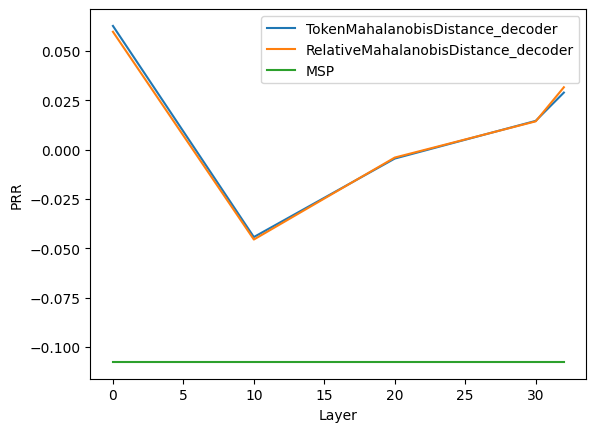

In [127]:
import matplotlib.pyplot as plt

def check_cond(col, name="TokenMahalanobisDistance_decoder", suf="(mean, AlignScore, 0.3)"):
    return (name in col) and (suf in col)
names = ["TokenMahalanobisDistance_decoder", "RelativeMahalanobisDistance_decoder"]
for name in names:
    cols = [x for x in df0.columns if check_cond(x, name)]
    layers = [int(x.split("_")[2].split(" ")[0]) if len(x.split("_")) > 2 else 32 for x in cols]
    
    plt.plot(layers, df0[cols].values[1], label=name)
plt.plot(layers, [df0['MaximumSequenceProbability'][1]]*len(layers), label="MSP")
plt.xlabel("Layer")
plt.ylabel("PRR")
plt.legend()

## Gemma 7b

In [131]:
path = "../workdir/output/ats/google/gemma-7b/xsum/2024-07-03/18-32-16/ue_manager_seed1"
man = torch.load(path)

metric_names = ['RougeL', 'AlignScore']
df = {}
for key in man['metrics'].keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man["metrics"][key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'SciQ, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"SciQ, {metric_names[-2]}, PRR", ascending=False).style.background_gradient(axis=0)

,"SciQ, RougeL, PRR","SciQ, AlignScore, PRR"
"RelativeMahalanobisDistance_decoder (mean, AlignScore, 0.3)",0.093400,0.093400
"RelativeMahalanobisDistance_decoder (sum, AlignScore, 0.3)",0.087578,0.087578
"RelativeMahalanobisDistance_decoder (sum, Rouge-L, 0.3)",0.043596,0.043596
"RelativeMahalanobisDistance_decoder_25 (mean, , 0)",0.041340,0.041340
"RelativeMahalanobisDistance_decoder_25 (mean, Accuracy, 0.3)",0.041340,0.041340
"RelativeMahalanobisDistance_decoder (mean, , 0)",0.038951,0.038951
"RelativeMahalanobisDistance_decoder (mean, Accuracy, 0.3)",0.038951,0.038951
"RelativeMahalanobisDistance_decoder_10 (mean, , 0)",0.034210,0.034210
"RelativeMahalanobisDistance_decoder_10 (mean, Accuracy, 0.3)",0.034210,0.034210
"RelativeMahalanobisDistance_decoder (mean, Rouge-L, 0.3)",0.033879,0.033879


/tmp/ipykernel_45993/2702456290.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(layers, [df0['MaximumSequenceProbability'][1]]*len(layers), label="MSP")


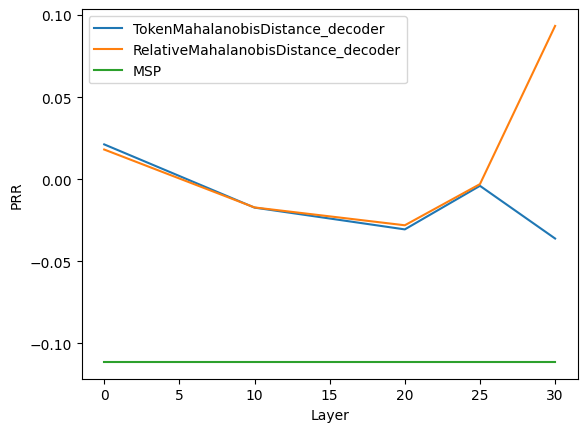

In [133]:
import matplotlib.pyplot as plt

def check_cond(col, name="TokenMahalanobisDistance_decoder", suf="(mean, AlignScore, 0.3)"):
    return (name in col) and (suf in col)
names = ["TokenMahalanobisDistance_decoder", "RelativeMahalanobisDistance_decoder"]
for name in names:
    cols = [x for x in df0.columns if check_cond(x, name)]
    layers = [int(x.split("_")[2].split(" ")[0]) if len(x.split("_")) > 2 else 30 for x in cols]
    
    plt.plot(layers, df0[cols].values[1], label=name)
plt.plot(layers, [df0['MaximumSequenceProbability'][1]]*len(layers), label="MSP")
plt.xlabel("Layer")
plt.ylabel("PRR")
plt.legend()

In [19]:
np.mean(man['gen_metrics'][('sequence', 'AlignScore')])

0.03941326216568268

# WMT 14 De-En

## Vicuna 7b

In [110]:
path = "lm-polygraph/workdir/output/nmt/lmsys/vicuna-7b-v1.5/['wmt14', 'de-en']/2024-04-09/23-14-31/ue_manager_seed1"
man = UEManager.load(path)

metric_names = ['Comet', 'AlignScore']
df = {}
for key in man.metrics.keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man.metrics[key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'WMT14 De-En, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"WMT14 De-En, {metric_names[-1]}, PRR", ascending=False).style.background_gradient(axis=0)

Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x7fc48b67cf40>]


,"WMT14 De-En, Comet, PRR","WMT14 De-En, AlignScore, PRR"
MeanTokenEntropy,0.274388,0.551702
Perplexity,0.233358,0.512977
MaximumSequenceProbability,0.244103,0.480413
"TokenMahalanobisDistance_decoder (mean, alignscore, 0.5)",0.199104,0.224835
"TokenMahalanobisDistance_decoder (mean, alignscore, 0.0)",0.193842,0.223493
"RelativeMahalanobisDistance_decoder (mean, alignscore, 0.5)",0.143306,0.116263
"RelativeMahalanobisDistance_decoder (sum, alignscore, 0.5)",0.140829,0.114453
"RelativeMahalanobisDistance_decoder (mean, alignscore, 0.0)",0.131894,0.109233
"RelativeMahalanobisDistance_decoder (sum, alignscore, 0.0)",0.136024,0.101627
"TokenMahalanobisDistance_decoder (sum, alignscore, 0.5)",0.068077,0.048075


In [111]:
np.mean(man.gen_metrics[('sequence', 'Comet')])

0.8373594695329666

In [112]:
path = "lm-polygraph/workdir/output/nmt/lmsys/vicuna-13b-v1.5/['wmt14', 'de-en']/2024-04-09/23-14-31/ue_manager_seed1"
man = UEManager.load(path)

metric_names = ['Comet', 'AlignScore']
df = {}
for key in man.metrics.keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man.metrics[key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'WMT14 De-En, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"WMT14 De-En, {metric_names[-1]}, PRR", ascending=False).style.background_gradient(axis=0)

Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x7fc48b67cf40>]


,"WMT14 De-En, Comet, PRR","WMT14 De-En, AlignScore, PRR"
MeanTokenEntropy,0.258356,0.542357
Perplexity,0.238769,0.493736
MaximumSequenceProbability,0.216374,0.431071
"TokenMahalanobisDistance_decoder (mean, alignscore, 0.0)",0.229777,0.342794
"TokenMahalanobisDistance_decoder (mean, alignscore, 0.5)",0.232429,0.341478
"RelativeMahalanobisDistance_decoder (mean, alignscore, 0.5)",0.166717,0.157677
"RelativeMahalanobisDistance_decoder (mean, alignscore, 0.0)",0.163551,0.154636
"RelativeMahalanobisDistance_decoder (sum, alignscore, 0.5)",0.165375,0.123471
"RelativeMahalanobisDistance_decoder (sum, alignscore, 0.0)",0.162751,0.115593
"TokenMahalanobisDistance_decoder (sum, alignscore, 0.0)",0.036914,0.010969


In [113]:
np.mean(man.gen_metrics[('sequence', 'Comet')])

0.8482999328076839

## Mistral 7b

In [114]:
path = "lm-polygraph/workdir/output/nmt/alpindale/Mistral-7B-v0.2-hf/['wmt14', 'de-en']/2024-04-10/05-39-15/ue_manager_seed1"
man = UEManager.load(path)

metric_names = ['Comet', 'AlignScore']
df = {}
for key in man.metrics.keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man.metrics[key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'WMT14 De-En, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"WMT14 De-En, {metric_names[-1]}, PRR", ascending=False).style.background_gradient(axis=0)

Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x7fc48b67cf40>]


,"WMT14 De-En, Comet, PRR","WMT14 De-En, AlignScore, PRR"
MeanTokenEntropy,0.008118,0.100074
MaximumSequenceProbability,-0.027159,0.033613
Perplexity,-0.022617,0.029431
"RelativeMahalanobisDistance_decoder (sum, alignscore, 0.0)",0.174806,-0.557457
"RelativeMahalanobisDistance_decoder (mean, alignscore, 0.0)",0.174661,-0.557478
"RelativeMahalanobisDistance_decoder (sum, alignscore, 0.5)",0.175602,-0.559307
"RelativeMahalanobisDistance_decoder (mean, alignscore, 0.5)",0.175552,-0.559364
"TokenMahalanobisDistance_decoder (sum, alignscore, 0.0)",0.077897,-0.568182
"TokenMahalanobisDistance_decoder (sum, alignscore, 0.5)",0.080204,-0.569053
"TokenMahalanobisDistance_decoder (mean, alignscore, 0.0)",0.101214,-0.596230


In [116]:
np.mean(man.gen_metrics[('sequence', 'Comet')])

0.5119356378316879

## Stablm 12b

In [119]:
path = "lm-polygraph/workdir/output/nmt/stabilityai/stablelm-2-12b/['wmt14', 'de-en']/2024-04-10/05-39-15/ue_manager_seed1"
man = UEManager.load(path)

metric_names = ['Comet', 'AlignScore']
df = {}
for key in man.metrics.keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man.metrics[key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'WMT14 De-En, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"WMT14 De-En, {metric_names[-1]}, PRR", ascending=False).style.background_gradient(axis=0)

Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x7fc48b67cf40>]


,"WMT14 De-En, Comet, PRR","WMT14 De-En, AlignScore, PRR"
MaximumSequenceProbability,0.262681,0.729212
MeanTokenEntropy,0.247645,0.587531
Perplexity,0.249943,0.579881
"TokenMahalanobisDistance_decoder (sum, alignscore, 0.5)",0.080823,0.449890
"TokenMahalanobisDistance_decoder (sum, alignscore, 0.0)",0.080889,0.449403
"TokenMahalanobisDistance_decoder (mean, alignscore, 0.5)",0.156284,0.016247
"TokenMahalanobisDistance_decoder (mean, alignscore, 0.0)",0.147046,-0.058706
"RelativeMahalanobisDistance_decoder (mean, alignscore, 0.5)",0.123638,-0.625219
"RelativeMahalanobisDistance_decoder (mean, alignscore, 0.0)",0.123479,-0.649622
"RelativeMahalanobisDistance_decoder (sum, alignscore, 0.5)",0.097356,-0.761433


In [120]:
np.mean(man.gen_metrics[('sequence', 'Comet')])

0.822441279232502

## Gemma 7b

In [21]:
path = "../workdir/output/nmt/google/gemma-7b/['wmt14', 'de-en']/2024-07-04/00-23-51/ue_manager_seed1"
man = torch.load(path)

metric_names = ['Comet', 'AlignScore']
df = {}
for key in man['metrics'].keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man["metrics"][key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'SciQ, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"SciQ, {metric_names[-2]}, PRR", ascending=False).style.background_gradient(axis=0)

,"SciQ, Comet, PRR","SciQ, AlignScore, PRR"
MeanTokenEntropy,0.236713,0.515602
Perplexity,0.219401,0.517674
"TokenMahalanobisDistance_decoder (mean, Accuracy, 0.3)",0.199091,0.296064
"RelativeMahalanobisDistance_decoder (mean, Accuracy, 0.3)",0.193679,0.282106
"TokenMahalanobisDistance_decoder (mean, AlignScore, 0.3)",0.176535,0.234058
"TokenMahalanobisDistance_decoder (mean, Rouge-L, 0.3)",0.176397,0.234343
"TokenMahalanobisDistance_decoder (mean, , 0)",0.174233,0.232726
"RelativeMahalanobisDistance_decoder_20 (mean, Rouge-L, 0.3)",0.174197,0.144511
"RelativeMahalanobisDistance_decoder_20 (mean, AlignScore, 0.3)",0.171717,0.144212
"RelativeMahalanobisDistance_decoder_25 (mean, AlignScore, 0.3)",0.170751,0.113226


In [22]:
np.mean(man['gen_metrics'][('sequence', 'Comet')])

0.8509953519105912

# MMLU

In [134]:
path = "../workdir/output/qa/{'path': 'google/gemma-7b', 'ensemble': False, 'mc': False, 'mc_seeds': None, 'dropout_rate': None, 'device_map': 'auto', 'attn_implementation': 'eager'}/['cais/mmlu', 'all']/2024-07-04/00-23-51/ue_manager_seed1"
man = torch.load(path)

metric_names = ['Accuracy', 'AlignScore']
df = {}
for key in man['metrics'].keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man["metrics"][key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'SciQ, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"SciQ, {metric_names[-2]}, PRR", ascending=False).style.background_gradient(axis=0)

,"SciQ, Accuracy, PRR","SciQ, AlignScore, PRR"
Perplexity,0.684251,0.680102
MaximumSequenceProbability,0.684251,0.680102
MeanTokenEntropy,0.666180,0.662203
"RelativeMahalanobisDistance_decoder_10 (mean, Rouge-L, 0.3)",0.260932,0.259156
"RelativeMahalanobisDistance_decoder_10 (mean, AlignScore, 0.3)",0.260932,0.259156
"RelativeMahalanobisDistance_decoder_10 (sum, AlignScore, 0.3)",0.260932,0.259156
"RelativeMahalanobisDistance_decoder_10 (sum, Accuracy, 0.3)",0.260932,0.259156
"RelativeMahalanobisDistance_decoder_10 (sum, Rouge-L, 0.3)",0.260932,0.259156
"RelativeMahalanobisDistance_decoder_10 (mean, Accuracy, 0.3)",0.260932,0.259156
"RelativeMahalanobisDistance_decoder_10 (sum, , 0)",0.218426,0.217390


In [135]:
np.mean(man['gen_metrics'][('sequence', 'Accuracy')])

0.659

/tmp/ipykernel_45993/1771217357.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(layers, [df0['MaximumSequenceProbability'][0]]*len(layers), label="MSP")


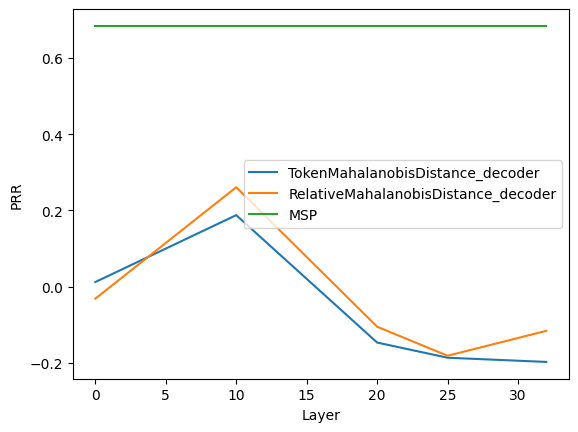

In [136]:
import matplotlib.pyplot as plt

def check_cond(col, name="TokenMahalanobisDistance_decoder", suf="(mean, AlignScore, 0.3)"):
    return (name in col) and (suf in col)
names = ["TokenMahalanobisDistance_decoder", "RelativeMahalanobisDistance_decoder"]
for name in names:
    cols = [x for x in df0.columns if check_cond(x, name)]
    layers = [int(x.split("_")[2].split(" ")[0]) if len(x.split("_")) > 2 else 32 for x in cols]
    
    plt.plot(layers, df0[cols].values[0], label=name)
plt.plot(layers, [df0['MaximumSequenceProbability'][0]]*len(layers), label="MSP")
plt.xlabel("Layer")
plt.ylabel("PRR")
plt.legend()

# TruthFulQA 

In [88]:
#path = "../workdir/output/qa/google/gemma-7b/['truthful_qa', 'generation']/2024-07-04/09-12-59/ue_manager_seed1"
path = "../workdir/output_layers/qa/google/gemma-7b/['truthful_qa', 'generation']/2024-07-08/17-39-19/ue_manager_seed1"
man = torch.load(path)

metric_names = ['Accuracy', 'AlignScore']
df = {}
for key in man['metrics'].keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man["metrics"][key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'SciQ, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"SciQ, {metric_names[-2]}, PRR", ascending=False).style.background_gradient(axis=0)

,"SciQ, Accuracy, PRR","SciQ, AlignScore, PRR"
MaximumSequenceProbability,0.644227,0.201462
"TokenMahalanobisDistance_decoder_20 (mean, Accuracy, 0.3)",0.580827,0.172404
"AverageTokenMahalanobisDistance_decoder18,19,20,21,22,23,24,25,26,-1 (mean, Accuracy, 0.3)",0.572383,0.253516
"TokenMahalanobisDistance_decoder (mean, Accuracy, 0.3)",0.524475,0.240298
"TokenMahalanobisDistance_decoder_25 (mean, Accuracy, 0.3)",0.511502,0.278168
Perplexity,0.497184,0.373512
MeanTokenEntropy,0.323442,0.321359
"TokenMahalanobisDistance_decoder_20 (mean, AlignScore, 0.3)",0.305356,0.185028
"TokenMahalanobisDistance_decoder (mean, AlignScore, 0.3)",0.280845,0.207531
"AverageTokenMahalanobisDistance_decoder18,19,20,21,22,23,24,25,26,-1 (mean, AlignScore, 0.3)",0.243493,0.219113


In [258]:
#path = "../workdir/output/qa/google/gemma-7b/['truthful_qa', 'generation']/2024-07-04/09-12-59/ue_manager_seed1"
path = "../workdir/output/qa/google/gemma-7b/['truthful_qa', 'generation']/2024-07-05/13-17-07/ue_manager_seed1"
man = torch.load(path)

metric_names = ['Accuracy', 'AlignScore']
df = {}
for key in man['metrics'].keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man["metrics"][key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'SciQ, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"SciQ, {metric_names[-1]}, PRR", ascending=False).style.background_gradient(axis=0)

,"SciQ, Accuracy, PRR","SciQ, AlignScore, PRR"
MeanTokenEntropy,0.228374,0.306074
Perplexity,0.381126,0.299013
"RelativeMahalanobisDistance_decoder_17 (mean, AlignScore, 0.6)",0.470648,0.298506
"TokenMahalanobisDistance_decoder_17 (mean, AlignScore, 0.6)",0.468409,0.296130
"RelativeMahalanobisDistance_decoder_21 (mean, AlignScore, 0.6)",0.403523,0.295010
"RelativeMahalanobisDistance_decoder_18 (mean, AlignScore, 0.9)",0.483823,0.289681
"TokenMahalanobisDistance_decoder_18 (mean, AlignScore, 0.9)",0.483810,0.289088
"TokenMahalanobisDistance_decoder_21 (mean, AlignScore, 0.6)",0.398624,0.289050
"RelativeMahalanobisDistance_decoder_18 (mean, AlignScore, 0.6)",0.466496,0.288324
"RelativeMahalanobisDistance_decoder_26 (mean, AlignScore, 0.9)",0.313416,0.286682


In [259]:
np.mean(man['gen_metrics'][('sequence', 'Accuracy')])

0.06601466992665037

/tmp/ipykernel_45993/2890486429.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(layers, [df0['MaximumSequenceProbability'][1]]*len(layers), label="MSP")


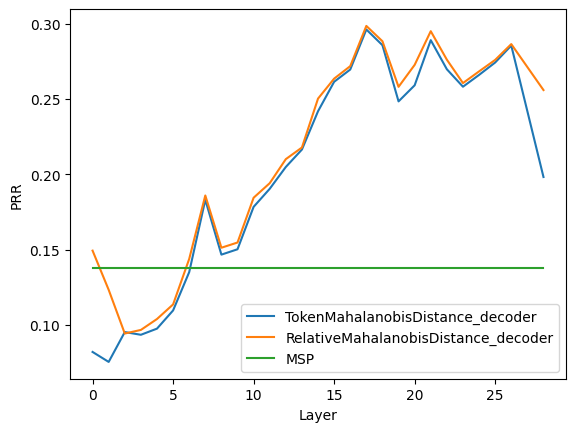

In [276]:
import matplotlib.pyplot as plt

def check_cond(col, name="TokenMahalanobisDistance_decoder", suf="(mean, AlignScore, 0.6)"):
    return (name in col) and (suf in col)
names = ["TokenMahalanobisDistance_decoder", "RelativeMahalanobisDistance_decoder"]
for name in names:
    cols = [x for x in df0.columns if check_cond(x, name)]
    layers = [int(x.split("_")[2].split(" ")[0]) if len(x.split("_")) > 2 else 28 for x in cols]
    
    plt.plot(layers, df0[cols].values[1], label=name)
plt.plot(layers, [df0['MaximumSequenceProbability'][1]]*len(layers), label="MSP")
plt.xlabel("Layer")
plt.ylabel("PRR")
plt.legend()

# Average

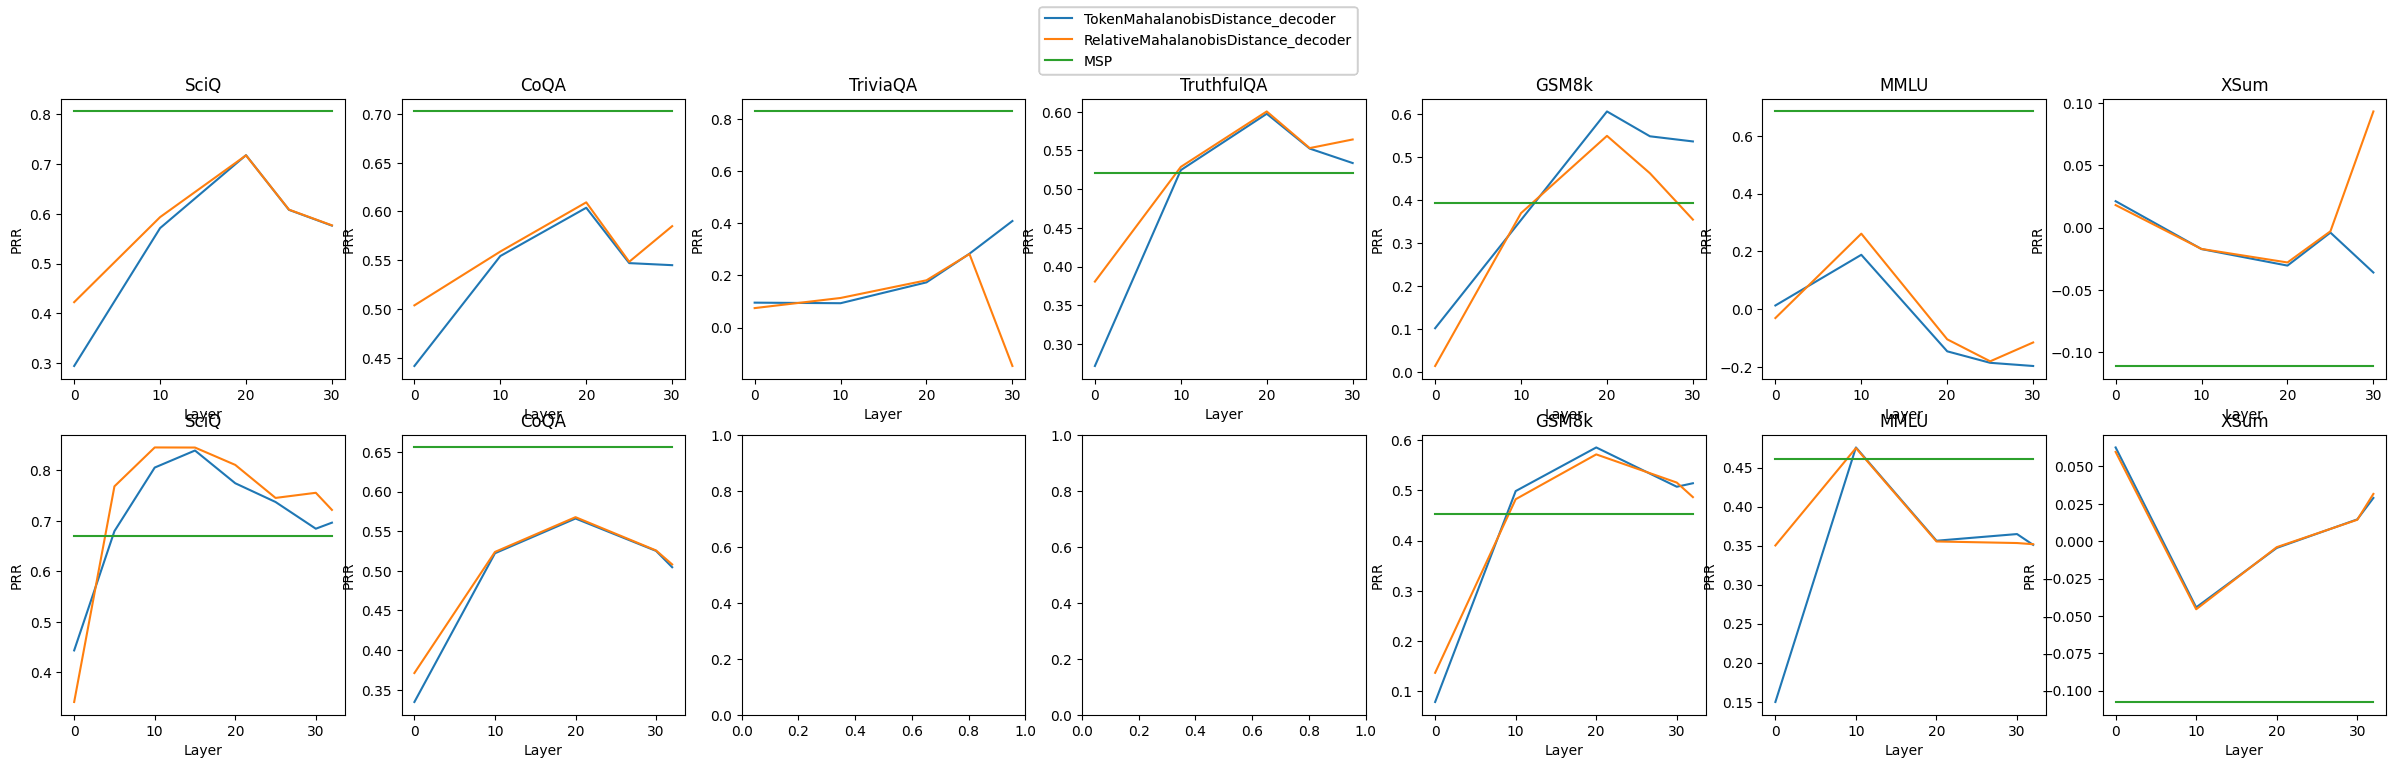

In [3]:
import matplotlib.pyplot as plt


paths_g = [
    "../workdir/output/qa/google/gemma-7b/sciq/2024-07-03/22-16-46/ue_manager_seed1",
    "../workdir/output/qa/google/gemma-7b/coqa/2024-07-03/18-32-21/ue_manager_seed1",
    "../workdir/output/qa/google/gemma-7b/['trivia_qa', 'rc.nocontext']/2024-07-04/01-41-50/ue_manager_seed1",
    "../workdir/output/qa/google/gemma-7b/['truthful_qa', 'generation']/2024-07-04/09-12-59/ue_manager_seed1",
    "../workdir/output/qa/google/gemma-7b/['gsm8k', 'main']/2024-07-03/18-32-16/ue_manager_seed1",
    "../workdir/output/qa/{'path': 'google/gemma-7b', 'ensemble': False, 'mc': False, 'mc_seeds': None, 'dropout_rate': None, 'device_map': 'auto', 'attn_implementation': 'eager'}/['cais/mmlu', 'all']/2024-07-04/00-23-51/ue_manager_seed1",
    "../workdir/output/ats/google/gemma-7b/xsum/2024-07-03/18-32-16/ue_manager_seed1",
]

paths_l = [
    "../workdir/output/qa/meta-llama/Meta-Llama-3-8B/sciq/2024-07-03/15-43-35/ue_manager_seed1",
    "../workdir/output/qa/meta-llama/Meta-Llama-3-8B/coqa/2024-07-04/11-11-14/ue_manager_seed1",
    "",
    "",
    "../workdir/output/qa/meta-llama/Meta-Llama-3-8B/['gsm8k', 'main']/2024-07-04/04-09-02/ue_manager_seed1",    
    "../workdir/output/qa/meta-llama/Meta-Llama-3-8B/['cais/mmlu', 'all']/2024-07-04/10-30-58/ue_manager_seed1",
    "../workdir/output/ats/meta-llama/Meta-Llama-3-8B/xsum/2024-07-04/04-09-02/ue_manager_seed1"
]
ds = ['SciQ', "CoQA", "TriviaQA", "TruthfulQA", "GSM8k", "MMLU", "XSum"]

def check_cond(col, name="TokenMahalanobisDistance_decoder", suf="(mean, Accuracy, 0.3)"):
        return (name in col) and (suf in col)
names = ["TokenMahalanobisDistance_decoder", "RelativeMahalanobisDistance_decoder"]

fig, ax = plt.subplots(nrows=2, ncols=7, figsize=(30, 8))

for k, (d_name, path) in enumerate(zip(ds, paths_g)):
    man = torch.load(path)
    metric_names = ['Accuracy', 'AlignScore']
    df = {}
    for key in man['metrics'].keys():
        if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
            scores = df.get(key[1], [])
            scores.append(man["metrics"][key])
            df[key[1]] = scores
            
    df0 = pd.DataFrame(df, index=[f'{d_name}, {m}, PRR' for m in metric_names])  
    if d_name == "SciQ":
        suf = "(mean, Accuracy, 0.3)"
        i = 0
    elif d_name == "XSum":
        suf = "(mean, AlignScore, 0.3)"
        i = 1
    else:
        suf="(mean, Accuracy, 0.3)"
        i = 0
    for name in names:
        cols = [x for x in df0.columns if check_cond(x, name, suf)]
        layers = [int(x.split("_")[2].split(" ")[0]) if len(x.split("_")) > 2 else 30 for x in cols]
        
        ax[0, k].plot(layers, df0[cols].values[i], label=name)
        
    ax[0, k].plot(layers, [df0['MaximumSequenceProbability'].iloc[i]]*len(layers), label="MSP")
    ax[0, k].set_xlabel("Layer")
    ax[0, k].set_ylabel("PRR")
    #ax[0, k].legend()
    ax[0, k].set_title(d_name)
    handles, labels = ax[0, k].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center')

for k, (d_name, path) in enumerate(zip(ds, paths_l)):
    if not len(path):
        continue
    man = torch.load(path)
    metric_names = ['Accuracy', 'AlignScore']
    df = {}
    for key in man['metrics'].keys():
        if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
            scores = df.get(key[1], [])
            scores.append(man["metrics"][key])
            df[key[1]] = scores
            
    df0 = pd.DataFrame(df, index=[f'{d_name}, {m}, PRR' for m in metric_names])  
    if d_name == "SciQ":
        suf = "(mean, accuracy, 0.5)"
        i = 0
    elif d_name == "XSum":
        suf = "(mean, AlignScore, 0.3)"
        i = 1
    else:
        suf="(mean, Accuracy, 0.3)"
        i = 0
    for name in names:
        cols = [x for x in df0.columns if check_cond(x, name, suf)]
        layers = [int(x.split("_")[2].split(" ")[0]) if len(x.split("_")) > 2 else 32 for x in cols]
        
        ax[1, k].plot(layers, df0[cols].values[i], label=name)
        
    ax[1, k].plot(layers, [df0['MaximumSequenceProbability'].iloc[i]]*len(layers), label="MSP")
    ax[1, k].set_xlabel("Layer")
    ax[1, k].set_ylabel("PRR")
    #ax[0, k].legend()
    ax[1, k].set_title(d_name)
    #handles, labels = ax[1, k].get_legend_handles_labels()
    #fig.legend(handles, labels, loc='upper center')

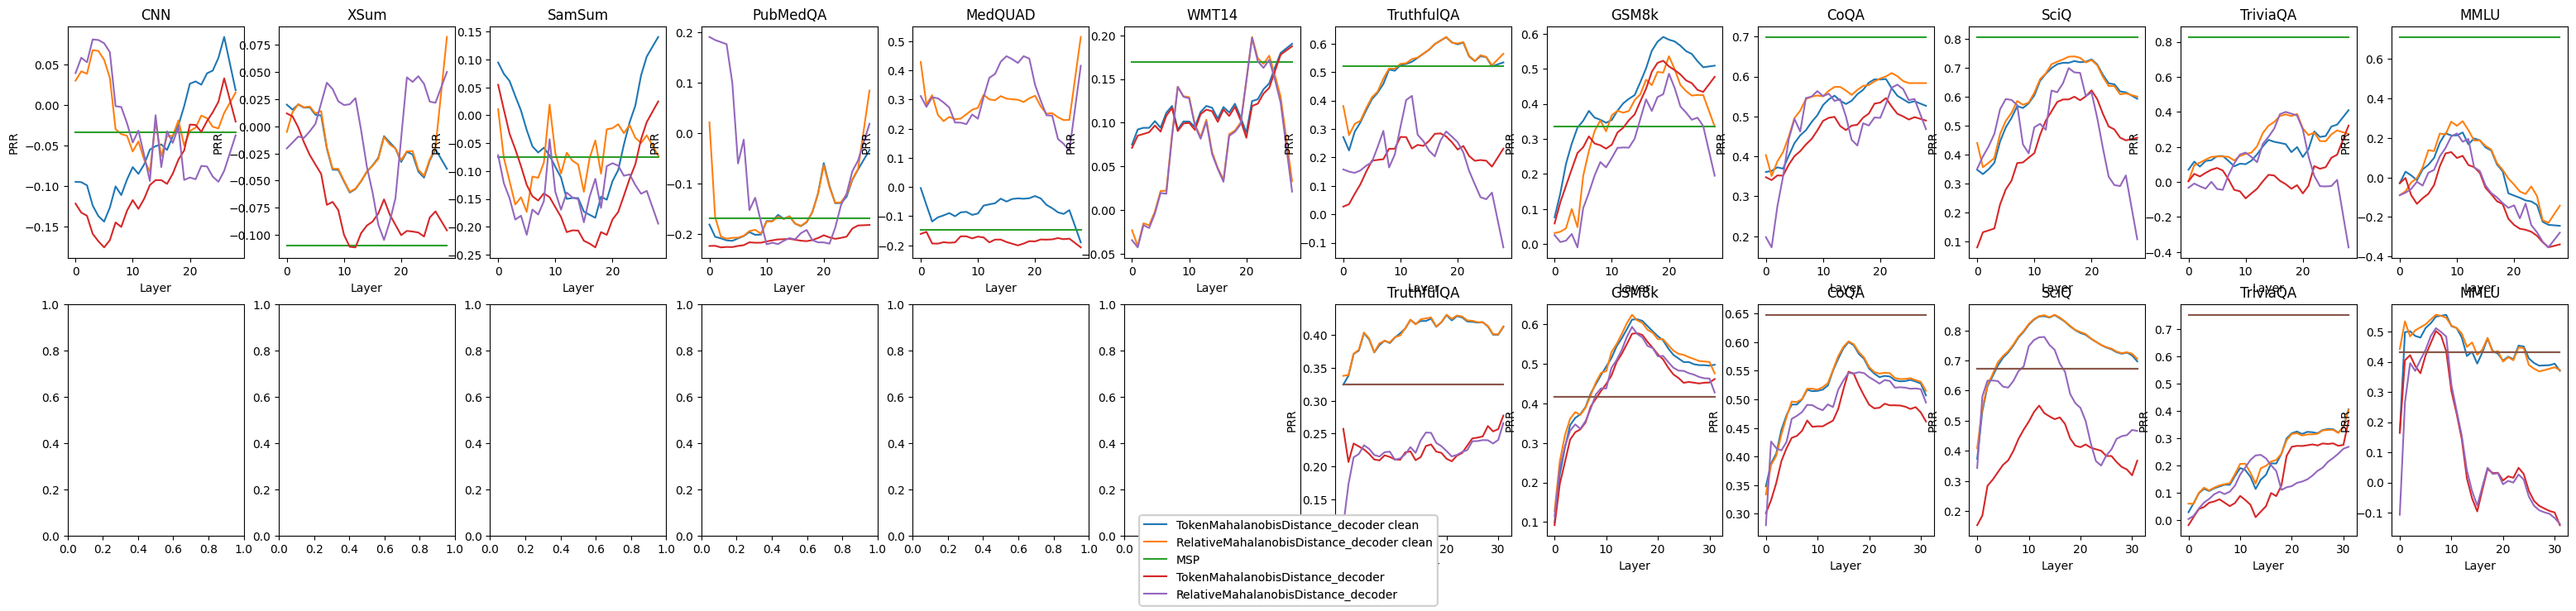

In [798]:
import matplotlib.pyplot as plt


paths_g = [
    "../workdir/output_layers/ats/google/gemma-7b/['cnn_dailymail', '3.0.0']/2024-07-07/11-41-26/ue_manager_seed1",
    "../workdir/output_layers/ats/google/gemma-7b/xsum/2024-07-06/11-31-14/ue_manager_seed1",
    "../workdir/output_layers/ats/google/gemma-7b/samsum/2024-07-08/12-16-27/ue_manager_seed1",
    "../workdir/output_layers/qa/google/gemma-7b/bigbio/pubmed_qa/2024-07-08/12-16-27/ue_manager_seed1",
    "../workdir/output_layers/qa/google/gemma-7b/keivalya/MedQuad-MedicalQnADataset/2024-07-06/22-55-47/ue_manager_seed1",
    "../workdir/output_layers/nmt/google/gemma-7b/['wmt14', 'de-en']/2024-07-06/22-55-47/ue_manager_seed1",
    "../workdir/output_layers/qa/google/gemma-7b/['truthful_qa', 'generation']/2024-07-08/01-42-11/ue_manager_seed1",
    "../workdir/output_layers/qa/google/gemma-7b/['gsm8k', 'main']/2024-07-06/11-31-14/ue_manager_seed1",
    "../workdir/output_layers/qa/google/gemma-7b/coqa/2024-07-05/17-04-45/ue_manager_seed1",
    "../workdir/output_layers/qa/google/gemma-7b/sciq/2024-07-06/07-38-03/ue_manager_seed1",
    "../workdir/output_layers/qa/google/gemma-7b/['trivia_qa', 'rc.nocontext']/2024-07-06/14-26-48/ue_manager_seed1",
    "../workdir/output_layers/qa/google/gemma-7b/['cais/mmlu', 'all']/2024-07-08/05-16-14/ue_manager_seed1"
]

paths_l = [
    "",
    "",
    "",
    "",
    "",
    "",
    "../workdir/output_layers/qa/meta-llama/Meta-Llama-3-8B/['truthful_qa', 'generation']/2024-07-11/05-58-43/ue_manager_seed1",
    "../workdir/output_layers/qa/meta-llama/Meta-Llama-3-8B/['gsm8k', 'main']/2024-07-07/22-06-40/ue_manager_seed1",
    "../workdir/output_layers/qa/meta-llama/Meta-Llama-3-8B/coqa/2024-07-08/16-59-16/ue_manager_seed1",
    "../workdir/output_layers/qa/meta-llama/Meta-Llama-3-8B/sciq/2024-07-11/10-38-50/ue_manager_seed1",
    "../workdir/output_layers/qa/meta-llama/Meta-Llama-3-8B/['trivia_qa', 'rc.nocontext']/2024-07-09/12-59-17/ue_manager_seed1",
    "../workdir/output_layers/qa/meta-llama/Meta-Llama-3-8B/['cais/mmlu', 'all']/2024-07-11/19-17-27/ue_manager_seed1",
]

ds = ["CNN", "XSum", "SamSum", "PubMedQA", "MedQUAD", "WMT14", "TruthfulQA", "GSM8k", "CoQA", 'SciQ', "TriviaQA", "MMLU"]

def check_cond(col, name="TokenMahalanobisDistance_decoder", suf="(mean, Accuracy, 0.3)"):
        return (name in col) and (suf in col)
names = ["TokenMahalanobisDistance_decoder", "RelativeMahalanobisDistance_decoder"]

fig, ax = plt.subplots(nrows=2, ncols=12, figsize=(39, 8))

for k, (d_name, path) in enumerate(zip(ds, paths_g)):
    man = torch.load(path)
    metric_names = ['Accuracy', 'AlignScore']
    df = {}
    for key in man['metrics'].keys():
        if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
            scores = df.get(key[1], [])
            scores.append(man["metrics"][key])
            df[key[1]] = scores
            
    df0 = pd.DataFrame(df, index=[f'{d_name}, {m}, PRR' for m in metric_names])  
    if d_name in ["CNN", "XSum", "MedQUAD", "WMT14", "SamSum", "PubMedQA"]:
        suf = "(mean, AlignScore, 0.3)"
        i = 1
    elif d_name in ["TruthfulQA"]:
        suf = "(mean, AlignScore, 0.3)"
        i = 1
    else:
        suf = "(mean, Accuracy, 0.3)"
        #suf="(mean, Accuracy, 0.3)"
        i = 0
    for name in names:
        cols = [x for x in df0.columns if check_cond(x, name, suf)]
        layers = [int(x.split("_")[2].split(" ")[0]) if len(x.split("_")) > 2 else 28 for x in cols]    
        ax[0, k].plot(layers, df0[cols].values[i], label=name +" clean")

    ax[0, k].plot(layers, [df0['MaximumSequenceProbability'].iloc[i]]*len(layers), label="MSP")


    if d_name in ["CNN", "XSum", "MedQUAD", "WMT14", "SamSum", "PubMedQA"]:
        suf = "(mean, , 0)"
        i = 1
    elif d_name in ["TruthfulQA"]:
        suf = "(mean, , 0)"
        i = 1
    else:
        suf = "(mean, , 0)"
        #suf="(mean, Accuracy, 0.3)"
        i = 0
    for name in names:
        cols = [x for x in df0.columns if check_cond(x, name, suf)]
        layers = [int(x.split("_")[2].split(" ")[0]) if len(x.split("_")) > 2 else 28 for x in cols]
        ax[0, k].plot(layers, df0[cols].values[i], label=name)
        
    ax[0, k].set_xlabel("Layer")
    ax[0, k].set_ylabel("PRR")
    #ax[0, k].legend()
    ax[0, k].set_title(d_name)
    handles, labels = ax[0, k].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center')

for k, (d_name, path) in enumerate(zip(ds, paths_l)):
    if not len(path):
        continue
    man = torch.load(path)
    metric_names = ['Accuracy', 'AlignScore']
    df = {}
    for key in man['metrics'].keys():
        if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
            scores = df.get(key[1], [])
            scores.append(man["metrics"][key])
            df[key[1]] = scores
            
    df0 = pd.DataFrame(df, index=[f'{d_name}, {m}, PRR' for m in metric_names])  
    if d_name in ["CNN", "XSum", "MedQUAD", "WMT14", "SamSum", "PubMedQA"]:
        suf = "(mean, AlignScore, 0.3)"
        i = 1
    elif d_name in ["TruthfulQA"]:
        suf = "(mean, Accuracy, 0.3)"
        i = 0
    else:
        suf = "(mean, Accuracy, 0.3)"
        #suf="(mean, Accuracy, 0.3)"
        i = 0
    for name in names:
        cols = [x for x in df0.columns if check_cond(x, name, suf)]
        layers = [int(x.split("_")[2].split(" ")[0]) if len(x.split("_")) > 2 else 31 for x in cols]    
        ax[1, k].plot(layers, df0[cols].values[i], label=name +" clean")

    ax[1, k].plot(layers, [df0['MaximumSequenceProbability'].iloc[i]]*len(layers), label="MSP")


    if d_name in ["CNN", "XSum", "MedQUAD", "WMT14", "SamSum", "PubMedQA"]:
        suf = "(mean, , 0)"
        i = 1
    elif d_name in ["TruthfulQA"]:
        suf = "(mean, , 0)"
        i = 0
    else:
        suf = "(mean, , 0)"
        #suf="(mean, Accuracy, 0.3)"
        i = 0
    for name in names:
        cols = [x for x in df0.columns if check_cond(x, name, suf)]
        layers = [int(x.split("_")[2].split(" ")[0]) if len(x.split("_")) > 2 else 31 for x in cols]
        ax[1, k].plot(layers, df0[cols].values[i], label=name)
        
    ax[1, k].plot(layers, [df0['MaximumSequenceProbability'].iloc[i]]*len(layers), label="MSP")
    ax[1, k].set_xlabel("Layer")
    ax[1, k].set_ylabel("PRR")
    #ax[0, k].legend()
    ax[1, k].set_title(d_name)
    #handles, labels = ax[1, k].get_legend_handles_labels()
    #fig.legend(handles, labels, loc='upper center')

/tmp/ipykernel_450/1147347277.py:106: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax[0, k].plot(layers, [df0[c][i]]*len(layers), label=label)
/tmp/ipykernel_450/1147347277.py:106: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax[0, k].plot(layers, [df0[c][i]]*len(layers), label=label)
/tmp/ipykernel_450/1147347277.py:106: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax[0, k].plot(layers, [df0[c][i]]*len(layers), label=label)
/tmp

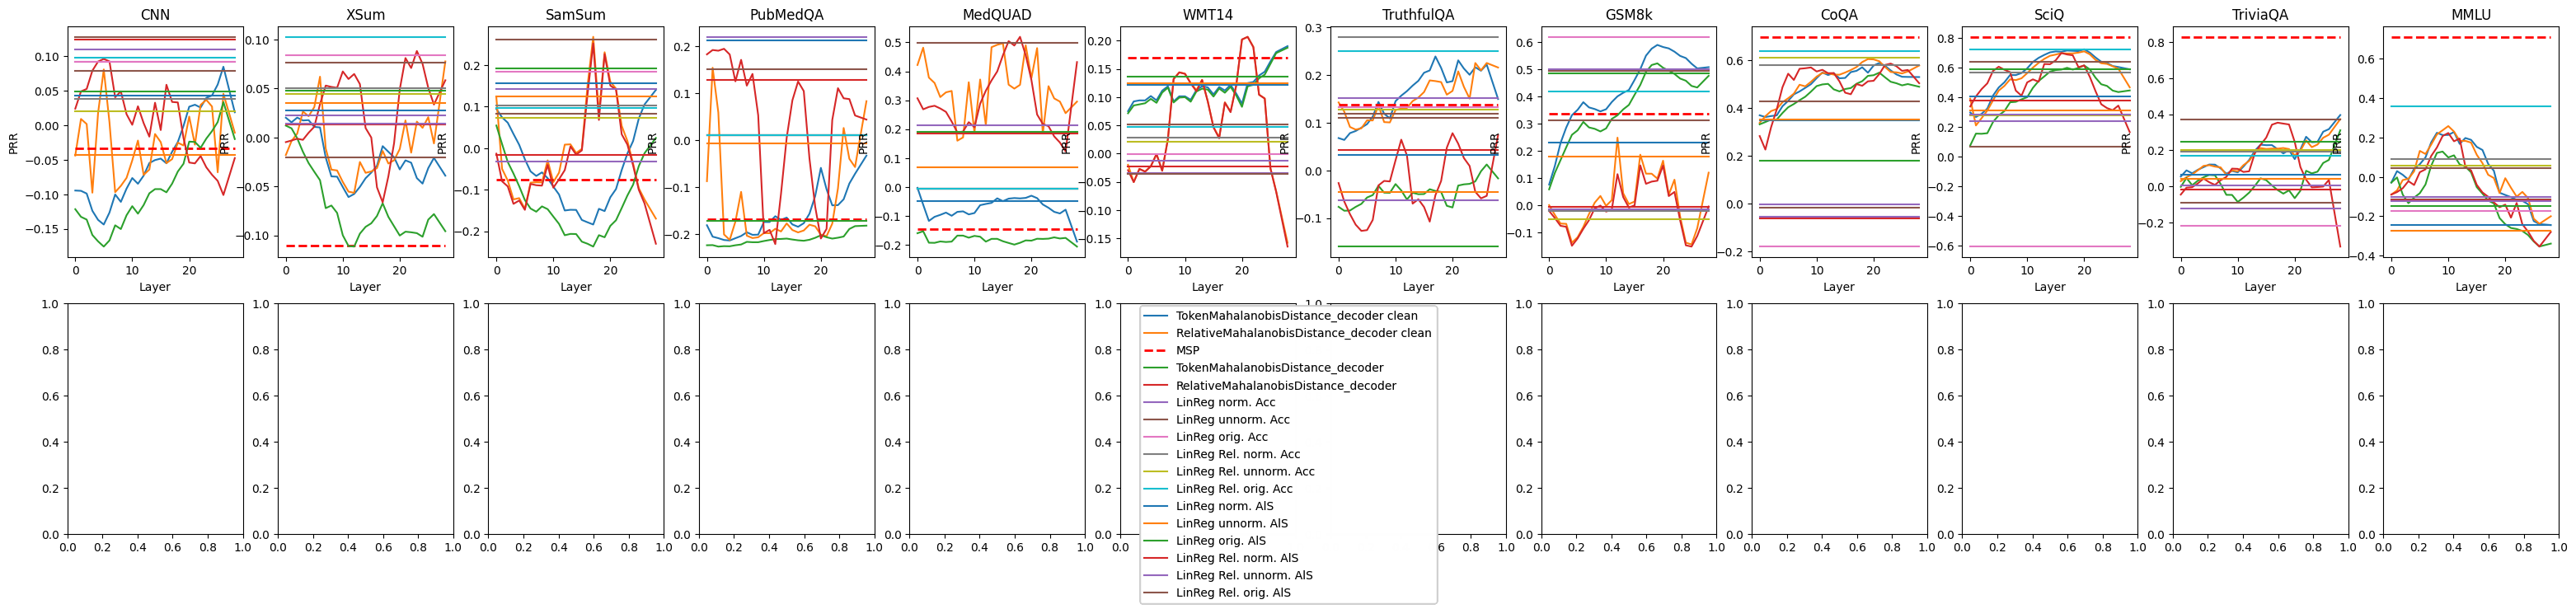

In [1231]:
import matplotlib.pyplot as plt


paths_g = [
    "../workdir/output_layers_2/ats/google/gemma-7b/['cnn_dailymail', '3.0.0']/2024-07-20/14-52-35/ue_manager_seed1",
    "../workdir/output_layers_2/ats/google/gemma-7b/xsum/2024-07-19/10-28-33/ue_manager_seed1",
    "../workdir/output_layers_2/ats/google/gemma-7b/samsum/2024-07-20/14-52-34/ue_manager_seed1",
    "../workdir/output_layers_2/qa/google/gemma-7b/bigbio/pubmed_qa/2024-07-21/03-41-01/ue_manager_seed1",
    "../workdir/output_layers_2/qa/google/gemma-7b/keivalya/MedQuad-MedicalQnADataset/2024-07-19/23-55-48/ue_manager_seed1",
    "../workdir/output_layers_2/nmt/google/gemma-7b/['wmt14', 'de-en']/2024-07-19/23-55-48/ue_manager_seed1",
    "../workdir/output_layers_2/qa/google/gemma-7b/['truthful_qa', 'generation']/2024-07-20/18-09-09/ue_manager_seed1",
    "../workdir/output_layers_2/qa/google/gemma-7b/['gsm8k', 'main']/2024-07-19/10-28-33/ue_manager_seed1",
    "../workdir/output_layers_2/qa/google/gemma-7b/coqa/2024-07-19/10-28-38/ue_manager_seed1",
    "../workdir/output_layers_2/qa/google/gemma-7b/sciq/2024-07-19/20-55-43/ue_manager_seed1",
    "../workdir/output_layers_2/qa/google/gemma-7b/['trivia_qa', 'rc.nocontext']/2024-07-20/01-17-01/ue_manager_seed1",
    "../workdir/output_layers_2/qa/google/gemma-7b/['cais/mmlu', 'all']/2024-07-20/20-46-43/ue_manager_seed1"
]

paths_l = [
    "",
    "",
    "",
    "",
    "",
    "",
    "",
    "",
    "",
    "",
    "",
    "",
    "",
]

ds = ["CNN", "XSum", "SamSum", "PubMedQA", "MedQUAD", "WMT14", "TruthfulQA", "GSM8k", "CoQA", 'SciQ', "TriviaQA", "MMLU"]

def check_cond(col, name="TokenMahalanobisDistance_decoder", suf="(mean, Accuracy, 0.3)"):
        return (name in col) and (suf in col)
names = ["TokenMahalanobisDistance_decoder", "RelativeMahalanobisDistance_decoder"]

fig, ax = plt.subplots(nrows=2, ncols=12, figsize=(39, 8))

for k, (d_name, path) in enumerate(zip(ds, paths_g)):
    man = torch.load(path)
    metric_names = ['Accuracy', 'AlignScore']
    df = {}
    for key in man['metrics'].keys():
        if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
            scores = df.get(key[1], [])
            scores.append(man["metrics"][key])
            df[key[1]] = scores
            
    df0 = pd.DataFrame(df, index=[f'{d_name}, {m}, PRR' for m in metric_names])  
    if d_name in ["CNN", "XSum", "MedQUAD", "WMT14", "SamSum", "PubMedQA"]:
        suf = "(mean, AlignScore, 0.3)"
        i = 1
    elif d_name in ["TruthfulQA"]:
        suf = "(mean, AlignScore, 0.3)"
        i = 1
    else:
        suf = "(mean, Accuracy, 0.3)"
        #suf="(mean, Accuracy, 0.3)"
        i = 0
    for name in names:
        cols = [x for x in df0.columns if check_cond(x, name, suf)]
        layers = [int(x.split("_")[2].split(" ")[0]) if len(x.split("_")) > 2 else 28 for x in cols]    
        ax[0, k].plot(layers, df0[cols].values[i], label=name +" clean")

    ax[0, k].plot(layers, [df0['MaximumSequenceProbability'].iloc[i]]*len(layers), label="MSP", linestyle="--", color="r", linewidth=2)


    if d_name in ["CNN", "XSum", "MedQUAD", "WMT14", "SamSum", "PubMedQA"]:
        suf = "(mean, , 0)"
        i = 1
    elif d_name in ["TruthfulQA"]:
        suf = "(mean, , 0)"
        i = 1
    else:
        suf = "(mean, , 0)"
        #suf="(mean, Accuracy, 0.3)"
        i = 0
    for name in names:
        cols = [x for x in df0.columns if check_cond(x, name, suf)]
        layers = [int(x.split("_")[2].split(" ")[0]) if len(x.split("_")) > 2 else 28 for x in cols]
        ax[0, k].plot(layers, df0[cols].values[i], label=name)

    for c in df0.columns:
        if "LinReg" not in c:
            continue
        label = "LinReg"
    
        if "relative" in c.lower():
            label += " Rel."
        
        if "unnorm" in c:
            label += " unnorm."
        elif "norm" in c:
            label += " norm."
        elif "orig" in c:
            label += " orig."
            
        if "Accuracy, Accuracy" in c:
            label += " Acc"
        if "AlignScore, AlignScore" in c:
            label += " AlS"        
        ax[0, k].plot(layers, [df0[c][i]]*len(layers), label=label)
            
    ax[0, k].set_xlabel("Layer")
    ax[0, k].set_ylabel("PRR")
    #ax[0, k].legend()
    ax[0, k].set_title(d_name)
    handles, labels = ax[0, k].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center')

for k, (d_name, path) in enumerate(zip(ds, paths_l)):
    if not len(path):
        continue
    man = torch.load(path)
    metric_names = ['Accuracy', 'AlignScore']
    df = {}
    for key in man['metrics'].keys():
        if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
            scores = df.get(key[1], [])
            scores.append(man["metrics"][key])
            df[key[1]] = scores
            
    df0 = pd.DataFrame(df, index=[f'{d_name}, {m}, PRR' for m in metric_names])  
    if d_name in ["CNN", "XSum", "MedQUAD", "WMT14", "SamSum", "PubMedQA"]:
        suf = "(mean, AlignScore, 0.3)"
        i = 1
    elif d_name in ["TruthfulQA"]:
        suf = "(mean, Accuracy, 0.3)"
        i = 0
    else:
        suf = "(mean, Accuracy, 0.3)"
        #suf="(mean, Accuracy, 0.3)"
        i = 0
    for name in names:
        cols = [x for x in df0.columns if check_cond(x, name, suf)]
        layers = [int(x.split("_")[2].split(" ")[0]) if len(x.split("_")) > 2 else 31 for x in cols]    
        ax[1, k].plot(layers, df0[cols].values[i], label=name +" clean")

    ax[1, k].plot(layers, [df0['MaximumSequenceProbability'].iloc[i]]*len(layers), label="MSP")


    if d_name in ["CNN", "XSum", "MedQUAD", "WMT14", "SamSum", "PubMedQA"]:
        suf = "(mean, , 0)"
        i = 1
    elif d_name in ["TruthfulQA"]:
        suf = "(mean, , 0)"
        i = 0
    else:
        suf = "(mean, , 0)"
        #suf="(mean, Accuracy, 0.3)"
        i = 0
    for name in names:
        cols = [x for x in df0.columns if check_cond(x, name, suf)]
        layers = [int(x.split("_")[2].split(" ")[0]) if len(x.split("_")) > 2 else 31 for x in cols]
        ax[1, k].plot(layers, df0[cols].values[i], label=name)
        
    ax[1, k].plot(layers, [df0['MaximumSequenceProbability'].iloc[i]]*len(layers), label="MSP")
    ax[1, k].set_xlabel("Layer")
    ax[1, k].set_ylabel("PRR")
    #ax[0, k].legend()
    ax[1, k].set_title(d_name)
    #handles, labels = ax[1, k].get_legend_handles_labels()
    #fig.legend(handles, labels, loc='upper center')

In [1246]:
a = np.array([-1, 1, -3, 2])
a / np.abs(a).sum()

array([-0.14285714,  0.14285714, -0.42857143,  0.28571429])

In [1628]:
path = "../workdir/output_layers_2/qa/google/gemma-7b/sciq/2024-07-19/20-55-43/ue_manager_seed1"
man = torch.load(path)

metric_names = ['Accuracy', 'AlignScore']
df = {}
for key in man['metrics'].keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man['metrics'][key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'CoQA, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"CoQA, {metric_names[-2]}, PRR", ascending=False).style.background_gradient(axis=0)

,"CoQA, Accuracy, PRR","CoQA, AlignScore, PRR"
MaximumSequenceProbability,0.805643,0.678682
"TokenMahalanobisDistance_decoder_20 (mean, Accuracy, 0.3)",0.721732,0.659673
"LinRegRelativeTokenMahalanobisDistance_decoder0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,-1 (mean, Accuracy, Accuracy, 0.3, , orig)",0.720032,0.642953
"TokenMahalanobisDistance_decoder_17 (mean, Accuracy, 0.3)",0.713083,0.632970
"TokenMahalanobisDistance_decoder_18 (mean, Accuracy, 0.3)",0.711256,0.658674
"TokenMahalanobisDistance_decoder_19 (mean, Accuracy, 0.3)",0.709348,0.658712
"RelativeMahalanobisDistance_decoder_20 (mean, Accuracy, 0.3)",0.707653,0.641229
"TokenMahalanobisDistance_decoder_15 (mean, Accuracy, 0.3)",0.707017,0.628236
"TokenMahalanobisDistance_decoder_16 (mean, Accuracy, 0.3)",0.705187,0.631927
"TokenMahalanobisDistance_decoder_14 (mean, Accuracy, 0.3)",0.700913,0.623665


In [1673]:
path = "../workdir/output_layers_2/qa/google/gemma-7b/sciq/2024-07-19/20-55-43/ue_manager_seed1"
data = torch.load(path)
layers = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,-1]
X_eval = []
y_eval = np.array(data["gen_metrics"][("sequence", "AlignScore")])
for l in layers:
    if l != -1:
        X_eval.append(data["estimations"][('sequence', f'TokenMahalanobisDistance_decoder_{l} (mean, AlignScore, 0.3)')])
    else:
        X_eval.append(data["estimations"][('sequence', f'TokenMahalanobisDistance_decoder (mean, AlignScore, 0.3)')])
    print(l, get_prr(X_eval[-1], y_eval))

X_eval = np.array(X_eval).T
X_eval.shape, y_eval.shape

0 0.0846615929447472
1 0.11570557060217707
2 0.12664693761274978
3 0.13247704407642288
4 0.19486437966892772
5 0.2512488317800179
6 0.2873305388431099
7 0.38362934602790755
8 0.39590912407928097
9 0.4107450323677575
10 0.4510566849456764
11 0.48839500525659985
12 0.5331265511591103
13 0.5607132151016239
14 0.6031154398298
15 0.6034399651797946
16 0.6169025319550842
17 0.6245717718451471
18 0.6458798757154246
19 0.654332226179254
20 0.656527230983212
21 0.6351964154857757
22 0.603703555660411
23 0.5758738960418482
24 0.568882268190312
25 0.5363229122148064
26 0.5310399592119046
-1 0.5538333713530977


((1000, 28), (1000,))

In [1674]:
import numpy as np
from scipy import stats

In [1675]:
bad_indices = []

for i in range(X_eval.shape[1]):
    bad_indices.append(np.argwhere((np.abs(np.corrcoef(X_eval.T)[i]) > 0.98) & (np.arange(X_eval.shape[1]) != i)).flatten())

In [1677]:
feats = np.arange(X_eval.shape[1])
removed = np.zeros_like(feats, dtype=bool)
added = np.zeros_like(feats, dtype=bool)

for f in feats:
    if removed[f]:
        continue
    added[f] = True
    # corrs = np.array([stats.pearsonr(x, X_eval.T[f]).statistic for x in X_eval.T])
    # corr_idx = np.argwhere((np.abs(corrs) > 0.9) & (np.arange(X_eval.shape[1]) != f)).flatten()
    
    # corr_idx = np.argwhere((np.abs(np.corrcoef(X_eval.T)[f]) > 0.8) & (np.arange(X_eval.shape[1]) != f)).flatten()
    corr_idx = np.argwhere((np.abs(np.corrcoef(X_eval.T)[f]) > 0.9)).flatten()
    removed[corr_idx] = True
    print(f, corr_idx)

0 [0 1 2 3]
4 [2 3 4 5 6]
7 [5 6 7 8 9]
10 [ 8  9 10 11 12]
13 [11 12 13 14 15 16 17]
18 [14 15 16 17 18 19 20 21]
22 [20 21 22 23 24 25]
26 [23 24 25 26]
27 [27]


In [1643]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import copy

def calculate_vif(X, thresh=200.0):
    # Taken from https://stats.stackexchange.com/a/253620/53565 and modified
    dropped = True
    drp_ind = []
    X_cp = copy.deepcopy(X)
    while dropped:
        feats = np.arange(X.shape[1])
        dropped = False
        vif = [variance_inflation_factor(X, f) for f in feats]
        print(vif)
        max_vif = max(vif)
        if max_vif > thresh:
            maxloc = np.argmax(vif)
            for i in np.arange(X_cp.shape[1]):
                if all(X_cp[:, i] == X[:, maxloc]):
                    drp_ind.append(i)
                    print(i, maxloc)
            X = np.delete(X, maxloc, 1)
            dropped=True
    return X, drp_ind

X_eval_, drp_ind = calculate_vif(copy.deepcopy(X_eval))

[144.2160593733191, 212.09915214445283, 511.5929478953443, 471.9479795292741, 659.6520706375576, 538.5239194254546, 557.3467254096881, 498.6438217329804, 446.85475764034067, 870.2313226992526, 1409.2136995534604, 1832.402206649668, 1681.417458272221, 1871.0691585110562, 2287.296652826098, 2320.773105864338, 2527.5174878011653, 1954.9752490656101, 1747.2898237633474, 1983.3272851662746, 1618.2388386179703, 1032.297662331271, 1035.152314369401, 1285.6421858281446, 1559.8747655725413, 2205.3449456556064, 1464.6947716944671, 77.07678845080517]
16 16
[143.82857154873423, 212.00093930985116, 510.08464274203027, 470.5510962544803, 659.2333362791977, 538.4316543035709, 556.5494563023087, 495.1934751675588, 445.7969448244801, 868.8312036944856, 1409.0185454646248, 1788.0211430037127, 1627.7161735561099, 1854.300648168718, 2259.8843428843074, 1822.8474995711856, 1296.6470443120154, 1733.8447091783435, 1969.6911916402978, 1616.7161986154122, 1025.4379139943005, 1034.3338596898188, 1285.3420097696

In [1644]:
X_eval_

array([[197.74499512, 761.94512939, 212.89677429, ...,  90.44390869,
        114.43184662, 139.28994751],
       [ 25.50933838,  36.32373428,  44.68458176, ...,  76.04582977,
         72.24446869,  65.41980743],
       [140.3447113 , 496.5904541 , 127.41162872, ...,  63.63002777,
         69.2456665 ,  76.33733368],
       ...,
       [ 51.02603149,  66.74905396,  73.14386749, ...,  68.17565155,
         70.13173676,  66.29410553],
       [108.36135864, 332.43234253, 129.1191864 , ...,  67.63922882,
         69.77747345,  68.56338501],
       [104.65659332, 345.16140747,  93.35748291, ...,  71.61834717,
         81.45282745,  84.51960754]])

In [1645]:
np.argwhere(~np.isin(np.arange(X_eval.shape[1]), drp_ind))

array([[ 0],
       [ 1],
       [ 3],
       [ 5],
       [ 8],
       [10],
       [17],
       [21],
       [27]])

In [1475]:
from sklearn.base import BaseEstimator, TransformerMixin
from statsmodels.stats.outliers_influence import variance_inflation_factor

class ReduceVIF(BaseEstimator, TransformerMixin):
    def __init__(self, thresh=10, impute=True, impute_strategy='median'):
        # From looking at documentation, values between 5 and 10 are "okay".
        # Above 10 is too high and so should be removed.
        self.thresh = thresh
        
        # The statsmodel function will fail with NaN values, as such we have to impute them.
        # By default we impute using the median value.
        # This imputation could be taken out and added as part of an sklearn Pipeline.
        if impute:
            self.imputer = Imputer(strategy=impute_strategy)

    def fit(self, X, y=None):
        print('ReduceVIF fit')
        if hasattr(self, 'imputer'):
            self.imputer.fit(X)
        return self

    def transform(self, X, y=None):
        print('ReduceVIF transform')
        columns = X.columns.tolist()
        if hasattr(self, 'imputer'):
            X = pd.DataFrame(self.imputer.transform(X), columns=columns)
        return ReduceVIF.calculate_vif(X, self.thresh)

    @staticmethod
    def calculate_vif(X, thresh=5.0):
        # Taken from https://stats.stackexchange.com/a/253620/53565 and modified
        dropped=True
        while dropped:
            variables = X.columns
            dropped = False
            vif = [variance_inflation_factor(X[variables].values, X.columns.get_loc(var)) for var in X.columns]
            
            max_vif = max(vif)
            if max_vif > thresh:
                maxloc = vif.index(max_vif)
                print(f'Dropping {X.columns[maxloc]} with vif={max_vif}')
                X = X.drop([X.columns.tolist()[maxloc]], axis=1)
                dropped=True
        return X

ModuleNotFoundError: No module named 'statsmodels'

In [1473]:
f = 2
np.argwhere((np.abs(np.corrcoef(X_eval.T)[f]) > 0.8) & (np.arange(X_eval.shape[1]) != f)).flatten()

array([0, 1, 3, 4, 5, 6])

In [1458]:
X_eval.T

(28, 1000)

In [1454]:
np.abs(np.corrcoef(X_eval.T))[0]

array([1.        , 0.98725537, 0.97747429, 0.9425059 , 0.87853488,
       0.82590394, 0.79545755, 0.72779887, 0.66792838, 0.59998215,
       0.55530335, 0.488673  , 0.42437135, 0.33668098, 0.30214807,
       0.26959265, 0.24388116, 0.22459556, 0.17454167, 0.11096356,
       0.09473309, 0.17679245, 0.30442557, 0.40788503, 0.44093348,
       0.51503773, 0.5223848 , 0.48583048])

In [1455]:
np.corrcoef(X_eval[:, added].T)

array([[1.        , 0.79545755, 0.42437135, 0.11096356, 0.51503773],
       [0.79545755, 1.        , 0.7590985 , 0.42543614, 0.72081779],
       [0.42437135, 0.7590985 , 1.        , 0.78044387, 0.79642709],
       [0.11096356, 0.42543614, 0.78044387, 1.        , 0.74721022],
       [0.51503773, 0.72081779, 0.79642709, 0.74721022, 1.        ]])

In [1443]:
X_eval[:, added].shape

(1000, 9)

(array([  6.,  38.,  77.,  84.,  78.,  91.,  90.,  93., 104.,  82.,  86.,
         52.,  38.,  28.,  15.,  14.,   8.,   8.,   4.,   4.]),
 array([ 36.68912506,  43.31855736,  49.94798965,  56.57742195,
         63.20685425,  69.83628654,  76.46571884,  83.09515114,
         89.72458344,  96.35401573, 102.98344803, 109.61288033,
        116.24231262, 122.87174492, 129.50117722, 136.13060951,
        142.76004181, 149.38947411, 156.0189064 , 162.6483387 ,
        169.277771  ]),
 <BarContainer object of 20 artists>)

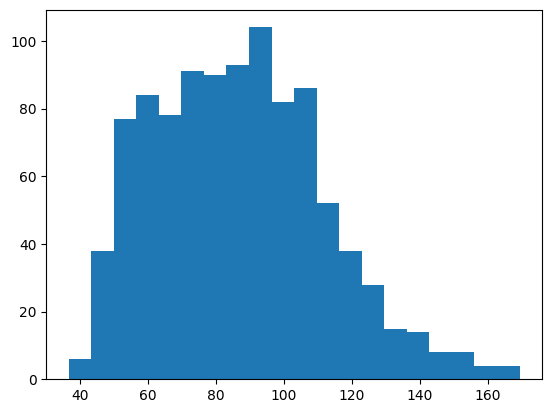

In [1308]:
plt.hist(X_eval[:, -20], bins=20)

In [45]:
data = torch.load(paths_g[5])

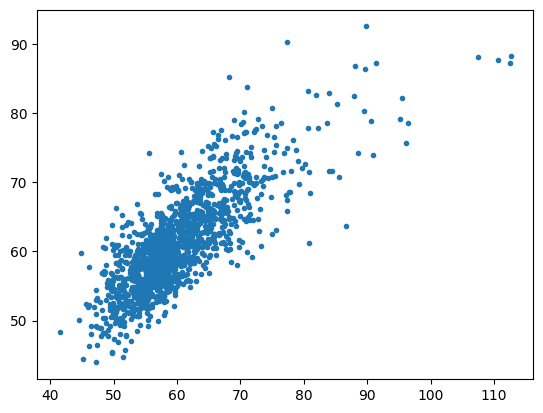

In [76]:
plt.plot(data["estimations"][('sequence', 'TokenMahalanobisDistance_decoder_19 (mean, Accuracy, 0.3)')], data["estimations"][('sequence', 'TokenMahalanobisDistance_decoder_26 (mean, Accuracy, 0.3)')], '.')

In [79]:
x = np.array([0,1,2,3])

np.mean([x, x], axis=0)

array([0., 1., 2., 3.])

In [70]:
from scipy import stats

for i in range(0, 27):
    res = stats.spearmanr(data["estimations"][('sequence', f'TokenMahalanobisDistance_decoder_{i} (mean, Accuracy, 0.3)')], data["estimations"][('sequence', 'TokenMahalanobisDistance_decoder_26 (mean, Accuracy, 0.3)')])
    print(i, res)

0 SignificanceResult(statistic=0.5883239164047777, pvalue=1.1887669896568716e-123)
1 SignificanceResult(statistic=0.6179168900266039, pvalue=9.981697136857276e-140)
2 SignificanceResult(statistic=0.7263102310814017, pvalue=1.1433281303358338e-216)
3 SignificanceResult(statistic=0.7668408379023506, pvalue=6.851694248305077e-256)
4 SignificanceResult(statistic=0.8087664712645608, pvalue=6.766480976721833e-306)
5 SignificanceResult(statistic=0.8350121085889395, pvalue=0.0)
6 SignificanceResult(statistic=0.8516739215757478, pvalue=0.0)
7 SignificanceResult(statistic=0.8536702519393674, pvalue=0.0)
8 SignificanceResult(statistic=0.831331851413418, pvalue=0.0)
9 SignificanceResult(statistic=0.799511345110778, pvalue=7.664538719511984e-294)
10 SignificanceResult(statistic=0.7920397935100403, pvalue=1.4539096213177617e-284)
11 SignificanceResult(statistic=0.7847433020025236, pvalue=7.273446198835599e-276)
12 SignificanceResult(statistic=0.7762849969532346, pvalue=3.389497040206605e-266)
13 Sig

In [75]:
for i in range(0, 27):
    print(i, data["metrics"][('sequence', f'TokenMahalanobisDistance_decoder_{i} (mean, Accuracy, 0.3)', 'Accuracy', 'prr_normalized')])

0 0.07638494187837333
1 0.1446084102147791
2 0.22935109819001603
3 0.28643317785032785
4 0.33185651868428045
5 0.3518091198728497
6 0.3798470080336639
7 0.36059571195203
8 0.3546118554900894
9 0.34592474620274294
10 0.35391148988442767
11 0.38042934483617363
12 0.4013310260439692
13 0.4144370256449713
14 0.4248290923243192
15 0.46201085794202007
16 0.5012705797055557
17 0.5512655484008924
18 0.5771019901459705
19 0.5908565292498663
20 0.5830788430329319
21 0.578020679196956
22 0.5660033991949046
23 0.5503111108462949
24 0.5423837795804004
25 0.5215101044991124
26 0.5043001970987899


# PersonBIO

In [4]:
seed = 1

base_path = "../workdir/fc/bio/mistralai/Mistral-7B-Instruct-v0.1/['rediska0123/person-bio']/"
time = "2024-07-05/10-23-35"#"2024-07-04/17-39-32"
#"2024-07-05/12-03-36"
data = {}


for fold in range(3):
    path1 = f"{base_path}/{time}/ue_manager_seed{seed}_fold{fold}"

    data1 = torch.load(path1)
    
    for k in data1.keys():
        if isinstance(data1[k], dict):
            if k not in data.keys():
                data[k] = {}
            for k1 in data1[k].keys():
                if isinstance(data1[k][k1], list):
                    if k1 not in data[k].keys():
                        data[k][k1] = data1[k][k1]
                    else:
                        data[k][k1] += data1[k][k1]
                else:
                    if k1 not in data[k].keys():
                        data[k][k1] = data1[k][k1]
                    else:
                        data[k][k1] += data1[k][k1]
                        
        elif isinstance(data1[k], list):
            data[k] = data1[k] + data2[k]
        else:
            print(k)

In [5]:
from lm_polygraph.ue_metrics import *

rocauc = ROCAUC()
prauc = PRAUC()

def preproc_method_name(x):
    return x

def get_table_upd(man, metric_names=['PR-AUC', "ROC-AUC"], dataset="CoQA", ue_metric="prr_normalized", 
                  update_alignscore=False, aggregated=False, return_score=False, level="claim"):
    df = {}
    methods = np.unique([x[1] for x in man['metrics'].keys() if "2side" not in x[1]])
    metric = np.array(man['gen_metrics'][('claim', 'OpenAIFactCheck')])  
    for method in methods:
        key = (level, method, "", ue_metric)
        level = "claim"
        if "relative" in method.lower():
            level = "sequence"
            print("")
        estimator_values = np.array(man['estimations'][(level, key[1])]).flatten()         
        rec_metrics_val = np.array(metric)

        ue = np.array(estimator_values)
        final_score = prauc(ue, rec_metrics_val) 
        scores = df.get(method, [])
        scores.append(final_score)
        df[method] = scores

    for method in methods:
        key = (level, method, "", ue_metric)
        level = "claim"
        if "relative" in method.lower():
            level = "sequence"
        estimator_values = np.array(man['estimations'][(level, key[1])]).flatten()         
        rec_metrics_val = np.array(metric)

        ue = np.array(estimator_values)
        final_score = rocauc(ue, rec_metrics_val) 
        scores = df.get(method, [])
        scores.append(final_score)
        df[method] = scores

    df0 = pd.DataFrame(df, index=pd.MultiIndex.from_tuples([(dataset, m) for m in metric_names])).T
    aggregation = ["mean" if "mean" in x else "sum(log(p_i))" if "sum(log(p_i))" in x else "-" for x in df0.index]
    method = [preproc_method_name(x) for x in df0.index]
    df0.loc[:, (dataset, 'Aggregation')] = aggregation
    df0.loc[:, (dataset, 'Method')] = method
    return df0.reset_index(drop=True)

In [6]:
get_table_upd(data).style.background_gradient(axis=0)

In [802]:
seed = 1

base_path = "../workdir/fc_new/bio/mistralai/Mistral-7B-Instruct-v0.1/['rediska0123/person-bio']/"
time = "2024-07-09/18-48-44"#"2024-07-09/16-58-57"#"2024-07-09/14-34-40"#"2024-07-09/13-04-52"
data = {}


for fold in range(5):
    path1 = f"{base_path}/{time}/ue_manager_seed{seed}_fold{fold}"

    data1 = torch.load(path1)
    
    for k in data1.keys():
        if isinstance(data1[k], dict):
            if k not in data.keys():
                data[k] = {}
            for k1 in data1[k].keys():
                if isinstance(data1[k][k1], list):
                    if k1 not in data[k].keys():
                        data[k][k1] = data1[k][k1]
                    else:
                        data[k][k1] += data1[k][k1]
                else:
                    if k1 not in data[k].keys():
                        data[k][k1] = data1[k][k1]
                    else:
                        data[k][k1] += data1[k][k1]
                        
        elif isinstance(data1[k], list):
            data[k] = data1[k] + data2[k]
        else:
            print(k)

In [803]:
from lm_polygraph.ue_metrics import *

rocauc = ROCAUC()
prauc = PRAUC()

def preproc_method_name(x):
    return x

def get_table_upd(man, metric_names=['PR-AUC', "ROC-AUC"], dataset="CoQA", ue_metric="prr_normalized", 
                  update_alignscore=False, aggregated=False, return_score=False, level="claim"):
    df = {}
    methods = np.unique([x[1] for x in man['estimations'].keys()])
    metric = np.array(man['gen_metrics'][('claim', 'OpenAIFactCheck')])  
    for method in methods:
        key = (level, method, "", ue_metric)
        level = "claim"
        if "relative" in method.lower() and "decoder_" in method.lower():
            level = "sequence"
            estimator_values = np.concatenate(man['estimations'][(level, key[1])])
        else:
            estimator_values = np.array(man['estimations'][(level, key[1])])
        
        rec_metrics_val = np.array(metric)

        ue = np.array(estimator_values)
        final_score = prauc(ue, rec_metrics_val) 
        scores = df.get(method, [])
        scores.append(final_score)
        df[method] = scores

    for method in methods:
        key = (level, method, "", ue_metric)
        level = "claim"
        if "relative" in method.lower() and "decoder_" in method.lower():
            level = "sequence"
            estimator_values = np.concatenate(man['estimations'][(level, key[1])])
        else:
            estimator_values = np.array(man['estimations'][(level, key[1])])       
        rec_metrics_val = np.array(metric)

        ue = np.array(estimator_values)
        final_score = rocauc(ue, rec_metrics_val) 
        scores = df.get(method, [])
        scores.append(final_score)
        df[method] = scores

    df0 = pd.DataFrame(df, index=pd.MultiIndex.from_tuples([(dataset, m) for m in metric_names])).T
    aggregation = ["mean" if "mean" in x else "sum(log(p_i))" if "sum(log(p_i))" in x else "-" for x in df0.index]
    method = [preproc_method_name(x) for x in df0.index]
    df0.loc[:, (dataset, 'Aggregation')] = aggregation
    df0.loc[:, (dataset, 'Method')] = method
    return df0.reset_index(drop=True)

In [804]:
df0 = get_table_upd(data)
df0.style.background_gradient(axis=0)

/tmp/ipykernel_722/3183765198.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(layers, [df0.iloc[0][1]]*len(layers), label="MSP")


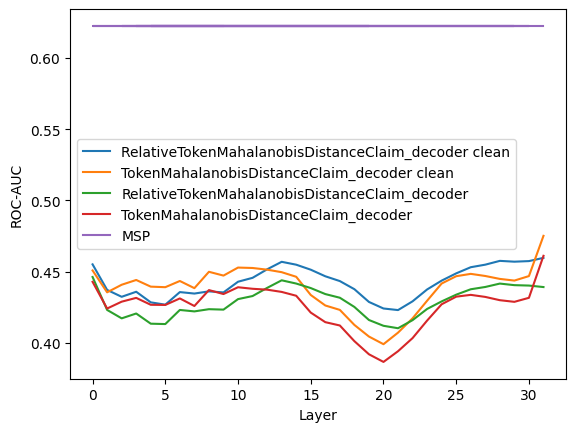

In [805]:
import matplotlib.pyplot as plt

def check_cond(col, name="TokenMahalanobisDistance_decoder", suf="(mean, 0.5)"):
    return (col.startswith(name)) and (suf in col)
    
names = ["RelativeTokenMahalanobisDistanceClaim_decoder", "TokenMahalanobisDistanceClaim_decoder"]
suf = "(mean, 0.5)"
for name in names:
    rows = [i for i, x in enumerate(df0[('CoQA', 'Method')].values) if check_cond(x, name, suf)]
    layers = np.array([int(x.split("_")[2].split(" ")[0]) if len(x.split("_")) > 2 else 31 for x in df0[('CoQA', 'Method')].values[rows]])
    order = np.argsort(layers)
    y = df0[('CoQA', 'ROC-AUC')].values[rows]
    plt.plot(layers[order], y[order], label=name + " clean")

suf = "(mean, 0.0)"
for name in names:
    rows = [i for i, x in enumerate(df0[('CoQA', 'Method')].values) if check_cond(x, name, suf)]
    layers = np.array([int(x.split("_")[2].split(" ")[0]) if len(x.split("_")) > 2 else 31 for x in df0[('CoQA', 'Method')].values[rows]])
    order = np.argsort(layers)
    y = df0[('CoQA', 'ROC-AUC')].values[rows]
    plt.plot(layers[order], y[order], label=name)


plt.plot(layers, [df0.iloc[0][1]]*len(layers), label="MSP")
plt.xlabel("Layer")
plt.ylabel("ROC-AUC")
plt.legend()

/tmp/ipykernel_722/280482669.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(layers, [df0.iloc[0][0]]*len(layers), label="MSP")


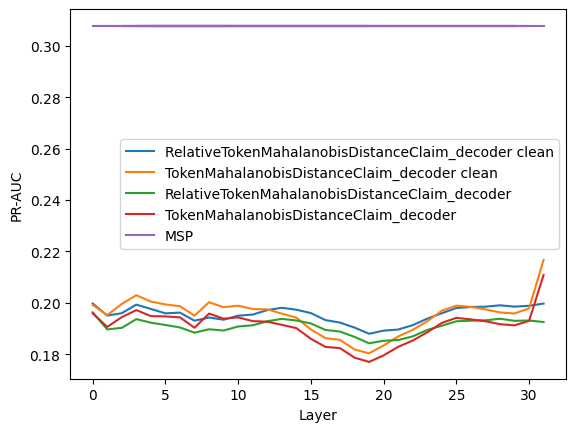

In [806]:
suf = "(mean, 0.5)"
for name in names:
    rows = [i for i, x in enumerate(df0[('CoQA', 'Method')].values) if check_cond(x, name, suf)]
    layers = np.array([int(x.split("_")[2].split(" ")[0]) if len(x.split("_")) > 2 else 31 for x in df0[('CoQA', 'Method')].values[rows]])
    order = np.argsort(layers)
    y = df0[('CoQA', 'PR-AUC')].values[rows]
    plt.plot(layers[order], y[order], label=name + " clean")

suf = "(mean, 0.0)"
for name in names:
    rows = [i for i, x in enumerate(df0[('CoQA', 'Method')].values) if check_cond(x, name, suf)]
    layers = np.array([int(x.split("_")[2].split(" ")[0]) if len(x.split("_")) > 2 else 31 for x in df0[('CoQA', 'Method')].values[rows]])
    order = np.argsort(layers)
    y = df0[('CoQA', 'PR-AUC')].values[rows]
    plt.plot(layers[order], y[order], label=name)

plt.plot(layers, [df0.iloc[0][0]]*len(layers), label="MSP")
plt.xlabel("Layer")
plt.ylabel("PR-AUC")
plt.legend()

In [742]:
len(data["stats"]["greedy_texts"])

80

In [705]:
from sacrebleu.metrics import BLEU, CHRF, TER

refs = [["This is a cat"]]#, ['The dog had bit the man.', 'No one was surprised.', 'The man had bitten the dog.']]
sys = ['This is cat']

bleu = BLEU(effective_order=True)

bleu.sentence_score(sys[0], [refs[0][0]])

BLEU = 45.14 100.0/50.0/50.0/0.0 (BP = 0.717 ratio = 0.750 hyp_len = 3 ref_len = 4)

In [178]:
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction

for t, g in zip(refs[0], sys):
    print(g, t)
    print(sentence_bleu([t.split()], g.split()))

This is cat This is a cat
8.987727354491445e-155


In [220]:
smth = SmoothingFunction(k=1)
for t, g in zip(refs[0], sys):
    print(g, t)
    print(sentence_bleu([t.split()], g.split(), smoothing_function=smth.method3, auto_reweigh=True))

This is cat This is a cat
0.451386440550339


In [186]:
SmoothingFunction()

In [273]:
import nltk
hypothesis = ['This', 'is', 'cat'] 
reference = ['This', 'is', 'a', 'cat']
references = [reference] # list of references for 1 sentence.
list_of_references = [references] # list of references for all sentences in corpus.
list_of_hypotheses = [hypothesis] # list of hypotheses that corresponds to list of references.
nltk.translate.bleu_score.corpus_bleu(list_of_references, list_of_hypotheses), nltk.translate.bleu_score.sentence_bleu(references, hypothesis)

(8.987727354491445e-155, 8.987727354491445e-155)

In [274]:
references, [t.split()]

([['This', 'is', 'a', 'cat']], [['This', 'is', 'a', 'cat']])

In [275]:
hypothesis, g.split()

(['This', 'is', 'cat'], ['This', 'is', 'cat'])

In [285]:
target = "yes"
gen = ' .Yes.\n'.lower().strip().rstrip('.')
bleu.sentence_score(gen, [target]).score

49.99999999999999

In [286]:
gen

'.yes'

In [ ]:
import numpy as np
from sacrebleu.metrics import BLEU

from typing import List, Dict
from .generation_metric import GenerationMetric


class RougeMetric(GenerationMetric):
    """
    Calculates BLEU metric between model-generated texts and ground truth texts.
    """

    def __init__(self):
        super().__init__(["greedy_texts"], "sequence")
        self.scorer = BLEU(effective_order=True)

    def __str__(self):
        return f"BLEU"

    def _score_single(self, t1: str, t2: str):
        return self.scorer.sentence_score(t1, [t2]).score

    def __call__(
        self,
        stats: Dict[str, np.ndarray],
        target_texts: List[str],
        target_tokens: List[List[int]],
    ) -> np.ndarray:
        """
        Calculates BLEU score between stats['greedy_texts'] and target_texts.

        Parameters:
            stats (Dict[str, np.ndarray]): input statistics, which for multiple samples includes:
                * model-generated texts in 'greedy_texts'
            target_texts (List[str]): ground-truth texts
            target_tokens (List[List[int]]): corresponding token splits for each target text
        Returns:
            np.ndarray: list of BLEU Scores for each sample in input.
        """
        return np.array(
            [
                self._score_single(hyp, ref)
                for hyp, ref in zip(stats["greedy_texts"], target_texts)
            ]
        )